In [1]:
from utils.get_marts import download_mart_as_parquet
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


import os
import requests
import shutil
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid') 
# Alternativ: plt.style.use('ggplot')
# Oder für interaktive Plots in manchen Umgebungen: %matplotlib widget


download_dir = "parquet_files"

file_path = download_mart_as_parquet(
        schema_name="main_analytics_marts", 
        mart_name="mart_user_tipping_behavior_timeseries", 
        fastapi_base_url="http://fastapi-backend-dabi2:3001",
        download_path=download_dir
    )


df = pd.read_parquet(file_path)
print("Erste 5 Zeilen des DataFrames:")
print(df.head())


Bibliotheken erfolgreich importiert.
Versuche Download von: http://fastapi-backend-dabi2:3001/api/v1/marts/main_analytics_marts/mart_user_tipping_behavior_timeseries/export/parquet
Datei erfolgreich heruntergeladen und gespeichert unter: parquet_files/main_analytics_marts_mart_user_tipping_behavior_timeseries.parquet
Test 1: Datei heruntergeladen nach: parquet_files/main_analytics_marts_mart_user_tipping_behavior_timeseries.parquet
Erste 5 Zeilen des DataFrames:
   user_id  order_id   order_timestamp  order_date_sk  user_order_sequence  \
0        3   1374495  1711893918000000       20240331                    1   
1        3    444309  1712691951000000       20240409                    2   
2        3   3002854  1714494320000000       20240430                    3   
3        3   2037211  1716229888000000       20240520                    4   
4        3   2710558  1717264347000000       20240601                    5   

   tip_given  tip_given_lag1  tip_given_lag2  tip_given_lag3  ti

# Jupyter Notebook: Analyse des Trinkgeldverhaltens

**Zielsetzung:** Untersuchung der Zeitreihe der Trinkgeldgabe pro User mittels autoregressiver Modelle (AR) und Analyse von Periodizität und Trends, um Vorhersagen über zukünftiges Trinkgeldverhalten zu treffen.


In [2]:
if not df.empty:
    print("--- DataFrame Info ---")
    df.info()
    print("\n--- Deskriptive Statistiken ---")
    print(df.describe(include='all')) 
    print("\n--- Fehlende Werte pro Spalte ---")
    print(df.isnull().sum())
    
    if 'user_id' in df.columns:
        print(f"\nAnzahl einzigartiger User: {df['user_id'].nunique()}")
    
    if 'order_timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['order_timestamp']):
        print(f"Zeitraum der Bestellungen: Von {df['order_timestamp'].min()} bis {df['order_timestamp'].max()}")
    elif 'order_timestamp' in df.columns:
        print("WARNUNG: 'order_timestamp' ist nicht im Datetime-Format. Bitte in Schritt 1 konvertieren.")

else:
    print("DataFrame ist leer. Keine Inspektion möglich.")

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463642 entries, 0 to 1463641
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   user_id              1463642 non-null  int64         
 1   order_id             1463642 non-null  int64         
 2   order_timestamp      1463642 non-null  int64         
 3   order_date_sk        1463642 non-null  int32         
 4   user_order_sequence  1463642 non-null  int64         
 5   tip_given            1401610 non-null  float64       
 6   tip_given_lag1       1401291 non-null  float64       
 7   tip_given_lag2       1339566 non-null  float64       
 8   tip_given_lag3       1277543 non-null  float64       
 9   tip_given_lag4       1215513 non-null  float64       
 10  tip_given_lag5       1161178 non-null  float64       
 11  full_date            1463642 non-null  datetime64[us]
 12  year                 1463642 non-

## 1. Datenvorbereitung und Feature Engineering


In [3]:
if not df.empty and 'order_timestamp' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['order_timestamp']):
        print(f"Ursprünglicher Datentyp von 'order_timestamp': {df['order_timestamp'].dtype}")
        print(f"Beispielwert vor Konvertierung: {df['order_timestamp'].iloc[0] if not df.empty else 'N/A'}")
        try:
            df['order_timestamp'] = pd.to_datetime(df['order_timestamp'], unit='us')
            print("'order_timestamp' erfolgreich zu datetime konvertiert (angenommene Einheit: Mikrosekunden).")
            print(f"Beispielwert nach Konvertierung: {df['order_timestamp'].iloc[0] if not df.empty else 'N/A'}")
        except Exception as e:
            print(f"Fehler bei der Konvertierung von 'order_timestamp': {e}")
            print("Überprüfe die Einheit des Timestamps (us, ms, ns) oder das Format.")
            print("Überspringe weitere Zeitstempel-Operationen.")
    else:
        print("'order_timestamp' ist bereits im datetime-Format.")

    try:
        df_indexed = df.set_index('order_timestamp')
        print("DataFrame mit 'order_timestamp' als Index (erste Zeilen):")
        print(df_indexed.head())
    except Exception as e:
        print(f"Fehler beim Setzen von 'order_timestamp' als Index: {e}")
    

    if 'user_id' in df.columns and 'order_timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['order_timestamp']):
        if 'user_order_sequence' in df.columns:
            df = df.sort_values(by=['user_id', 'user_order_sequence'])
            print("DataFrame nach 'user_id' und 'user_order_sequence' sortiert.")
        else: 
            df = df.sort_values(by=['user_id', 'order_timestamp'])
            print("DataFrame nach 'user_id' und 'order_timestamp' sortiert.")
    elif 'user_id' in df.columns:
        print("WARNUNG: 'order_timestamp' konnte nicht für die Sortierung verwendet werden oder fehlt. Sortierung möglicherweise unvollständig.")
else:
    print("DataFrame ist leer oder 'order_timestamp' Spalte fehlt. Überspringe Zeitstempel-Konvertierung.")

if not df.empty and 'order_timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['order_timestamp']):
    print("\nErste Zeilen des DataFrames mit potenziell korrigiertem 'order_timestamp':")
    print(df[['user_id', 'order_id', 'order_timestamp', 'tip_given']].head())
elif not df.empty:
    print("\n'order_timestamp' konnte nicht korrekt konvertiert oder gefunden werden. Überprüfe die vorherigen Schritte.")

Ursprünglicher Datentyp von 'order_timestamp': int64
Beispielwert vor Konvertierung: 1711893918000000
'order_timestamp' erfolgreich zu datetime konvertiert (angenommene Einheit: Mikrosekunden).
Beispielwert nach Konvertierung: 2024-03-31 14:05:18
DataFrame mit 'order_timestamp' als Index (erste Zeilen):
                     user_id  order_id  order_date_sk  user_order_sequence  \
order_timestamp                                                              
2024-03-31 14:05:18        3   1374495       20240331                    1   
2024-04-09 19:45:51        3    444309       20240409                    2   
2024-04-30 16:25:20        3   3002854       20240430                    3   
2024-05-20 18:31:28        3   2037211       20240520                    4   
2024-06-01 17:52:27        3   2710558       20240601                    5   

                     tip_given  tip_given_lag1  tip_given_lag2  \
order_timestamp                                                  
2024-03-31 14:05

In [4]:
if not df.empty:
    if 'tip_given' in df.columns:
        print(f"Einzigartige Werte in 'tip_given': {df['tip_given'].unique()}")
        if not pd.api.types.is_numeric_dtype(df['tip_given']):
            try:
                df['tip_given'] = df['tip_given'].astype(int)
                print("'tip_given' erfolgreich zu Integer konvertiert.")
            except Exception as e:
                print(f"WARNUNG: 'tip_given' konnte nicht zu Integer konvertiert werden: {e}")
        print(f"Datentyp von 'tip_given': {df['tip_given'].dtype}")
    else:
        print("WARNUNG: Spalte 'tip_given' nicht im DataFrame gefunden.")

    for i in range(1, 6): 
        lag_col = f'tip_given_lag{i}'
        if lag_col in df.columns:
            print(f"Einzigartige Werte in '{lag_col}': {df[lag_col].unique()}")
            if not pd.api.types.is_numeric_dtype(df[lag_col]):
                 try:
                    df[lag_col] = pd.to_numeric(df[lag_col], errors='coerce').astype('Int64')
                    print(f"'{lag_col}' erfolgreich zu Int64 (mit NaNs) konvertiert.")
                 except Exception as e:
                    print(f"WARNUNG: '{lag_col}' konnte nicht zu Int64 konvertiert werden: {e}")
            print(f"Datentyp von '{lag_col}': {df[lag_col].dtype}")
        # else:
else:
    print("DataFrame ist leer. Keine Prüfung der Ziel- und Lag-Variablen möglich.")


Einzigartige Werte in 'tip_given': [ 1.  0. nan]
Datentyp von 'tip_given': float64
Einzigartige Werte in 'tip_given_lag1': [nan  1.  0.]
Datentyp von 'tip_given_lag1': float64
Einzigartige Werte in 'tip_given_lag2': [nan  1.  0.]
Datentyp von 'tip_given_lag2': float64
Einzigartige Werte in 'tip_given_lag3': [nan  1.  0.]
Datentyp von 'tip_given_lag3': float64
Einzigartige Werte in 'tip_given_lag4': [nan  1.  0.]
Datentyp von 'tip_given_lag4': float64
Einzigartige Werte in 'tip_given_lag5': [nan  1.  0.]
Datentyp von 'tip_given_lag5': float64


In [5]:
if not df.empty:
    print("--- Umgang mit NaN in Lag-Spalten ---")
    print("Die ersten n Bestellungen eines Users werden NaN für tip_given_lagN haben.")
    print("Für die AR-Modellierung müssen diese Zeilen oft entfernt werden.")
    print("Beispiel: Anzahl NaNs in tip_given_lag1 und tip_given_lag2")
    if 'tip_given_lag1' in df.columns:
        print(f"NaNs in tip_given_lag1: {df['tip_given_lag1'].isnull().sum()}")
    if 'tip_given_lag2' in df.columns:
        print(f"NaNs in tip_given_lag2: {df['tip_given_lag2'].isnull().sum()}")

    if 'tip_given_lag1' in df.columns:
        df_for_ar1 = df.dropna(subset=['tip_given_lag1'])
        print(f"\nShape des DataFrames für AR(1) nach dropna: {df_for_ar1.shape}")
    else:
        print("Spalte 'tip_given_lag1' nicht vorhanden für AR(1)-Filterbeispiel.")

    if 'tip_given_lag1' in df.columns and 'tip_given_lag2' in df.columns:
        df_for_ar2 = df.dropna(subset=['tip_given_lag1', 'tip_given_lag2'])
        print(f"Shape des DataFrames für AR(2) nach dropna: {df_for_ar2.shape}")
    else:
        print("Spalten für AR(2)-Filterbeispiel nicht vollständig vorhanden.")
else:
    print("DataFrame ist leer.")


--- Umgang mit NaN in Lag-Spalten ---
Die ersten n Bestellungen eines Users werden NaN für tip_given_lagN haben.
Für die AR-Modellierung müssen diese Zeilen oft entfernt werden.
Beispiel: Anzahl NaNs in tip_given_lag1 und tip_given_lag2
NaNs in tip_given_lag1: 62351
NaNs in tip_given_lag2: 124076

Shape des DataFrames für AR(1) nach dropna: (1401291, 20)
Shape des DataFrames für AR(2) nach dropna: (1339248, 20)


--- Analyse von User-spezifischen Zeitreihen ---

Verteilung der Bestellungen pro User (Top 10):
user_id
91035     100
138283    100
138311    100
8419      100
8420      100
53837     100
53488     100
138791    100
183985    100
184906    100
Name: count, dtype: int64


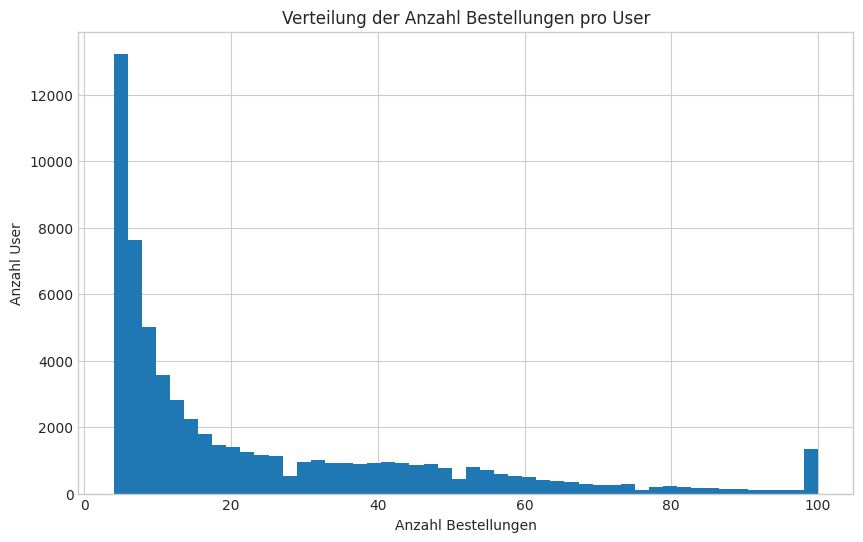


Anzahl User mit >= 10 Bestellungen: 36154
Shape des gefilterten DataFrames (nur User mit >= 10 Bestellungen): (1313565, 20)


In [6]:
if not df.empty and 'user_id' in df.columns:
    print("--- Analyse von User-spezifischen Zeitreihen ---")
    
    orders_per_user = df['user_id'].value_counts()
    print("\nVerteilung der Bestellungen pro User (Top 10):")
    print(orders_per_user.head(10))
    
    plt.figure(figsize=(10, 6))
    orders_per_user.hist(bins=50)
    plt.title('Verteilung der Anzahl Bestellungen pro User')
    plt.xlabel('Anzahl Bestellungen')
    plt.ylabel('Anzahl User')
    plt.show()

    MIN_ORDERS_PER_USER = 10 
    
    users_with_enough_orders = orders_per_user[orders_per_user >= MIN_ORDERS_PER_USER].index.tolist()
    print(f"\nAnzahl User mit >= {MIN_ORDERS_PER_USER} Bestellungen: {len(users_with_enough_orders)}")

    if users_with_enough_orders:
        df_filtered_users = df[df['user_id'].isin(users_with_enough_orders)].copy() # .copy() um SettingWithCopyWarning zu vermeiden
        print(f"Shape des gefilterten DataFrames (nur User mit >= {MIN_ORDERS_PER_USER} Bestellungen): {df_filtered_users.shape}")
    else:
        print(f"Keine User mit mindestens {MIN_ORDERS_PER_USER} Bestellungen gefunden. Überdenke den Schwellenwert oder die Daten.")
        df_filtered_users = pd.DataFrame() 
else:
    print("DataFrame ist leer oder 'user_id' Spalte fehlt.")
    df_filtered_users = pd.DataFrame()


## 2. Explorative Datenanalyse (EDA) – Periodizität und Trend (Fragen d, e)

Dieser Abschnitt beantwortet die Fragen zur Periodizität und zum Trend, bevor die AR-Modelle gebaut werden. Wir verwenden hierfür den `df_filtered_users` DataFrame, um eine robustere Analyse zu gewährleisten, oder den gesamten `df`, falls die Filterung nicht gewünscht ist.


In [7]:
df_eda = df_filtered_users if not df_filtered_users.empty else df

if not df_eda.empty and 'tip_given' in df_eda.columns:
    print("--- Analyse der Periodizität des Trinkgeldverhaltens ---")

    overall_tip_rate = df_eda['tip_given'].mean()
    print(f"Durchschnittliche Trinkgeldrate insgesamt: {overall_tip_rate:.2%}")

    if 'day_of_week' in df_eda.columns:
        tip_rate_by_dow = df_eda.groupby('day_of_week')['tip_given'].mean().sort_index()
        print("\nTrinkgeldrate pro Wochentag:")
        print(tip_rate_by_dow)
    else:
        print("Spalte 'day_of_week' nicht im DataFrame.")

    if 'month' in df_eda.columns:
        month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                       'July', 'August', 'September', 'October', 'November', 'December']
        if pd.api.types.is_string_dtype(df_eda['month']):
             try:
                df_eda['order_month_name_cat'] = pd.Categorical(df_eda['order_month_name'], categories=month_order, ordered=True)
                tip_rate_by_month = df_eda.groupby('order_month_name_cat', observed=False)['tip_given'].mean().sort_index()
                print("\nTrinkgeldrate pro Monat:")
                print(tip_rate_by_month)
             except KeyError: 
                print("WARNUNG: Einige Monatsnamen in 'order_month_name' sind nicht in der Standardreihenfolge. Ausgabe könnte unsortiert sein.")
                tip_rate_by_month = df_eda.groupby('order_month_name')['tip_given'].mean()
                print(tip_rate_by_month)

        else: 
            tip_rate_by_month = df_eda.groupby('month')['tip_given'].mean().sort_index()
            print("\nTrinkgeldrate pro Monat (basierend auf vorhandener 'order_month_name' Spalte):")
            print(tip_rate_by_month)


    else:
        print("Spalte 'month' nicht im DataFrame.")

    if 'quarter' in df_eda.columns:
        tip_rate_by_quarter = df_eda.groupby('quarter')['tip_given'].mean().sort_index()
        print("\nTrinkgeldrate pro Quartal:")
        print(tip_rate_by_quarter)
    else:
        print("Spalte 'order_quarter' nicht im DataFrame.")

    if 'is_weekend' in df_eda.columns:
        tip_rate_by_weekend = df_eda.groupby('is_weekend')['tip_given'].mean()
        print("\nTrinkgeldrate Wochenende vs. Wochentag:")
        print(tip_rate_by_weekend)
    else:
        print("Spalte 'is_weekend' nicht im DataFrame.")
else:
    print("DataFrame für EDA ist leer oder 'tip_given' fehlt.")



--- Analyse der Periodizität des Trinkgeldverhaltens ---
Durchschnittliche Trinkgeldrate insgesamt: 53.69%

Trinkgeldrate pro Wochentag:
day_of_week
0    0.643975
1    0.481720
2    0.475812
3    0.481503
4    0.487455
5    0.485881
6    0.645170
Name: tip_given, dtype: float64

Trinkgeldrate pro Monat (basierend auf vorhandener 'order_month_name' Spalte):
month
1     0.548691
2     0.535236
3     0.535521
4     0.522543
5     0.524310
6     0.541395
7     0.528429
8     0.537725
9     0.548876
10    0.541157
11    0.550261
12    0.553628
Name: tip_given, dtype: float64

Trinkgeldrate pro Quartal:
quarter
1    0.538580
2    0.528917
3    0.537599
4    0.547936
Name: tip_given, dtype: float64

Trinkgeldrate Wochenende vs. Wochentag:
is_weekend
False    0.516431
True     0.645170
Name: tip_given, dtype: float64


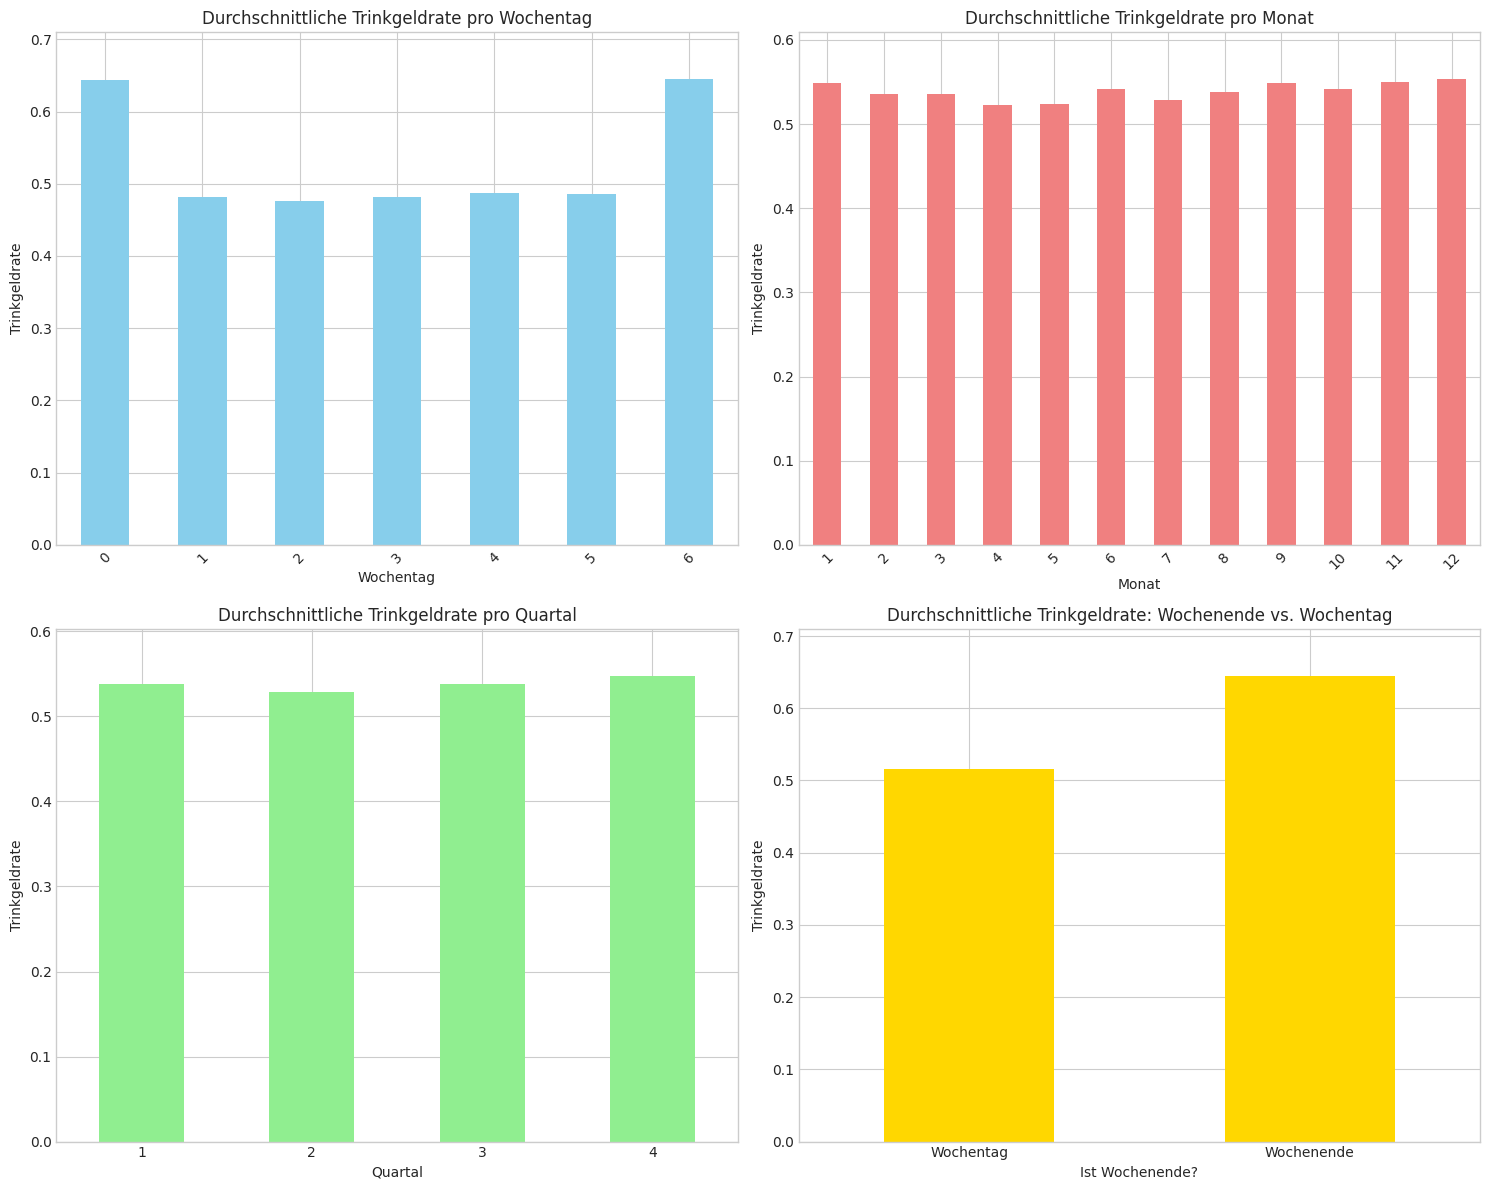

<Figure size 1200x400 with 0 Axes>

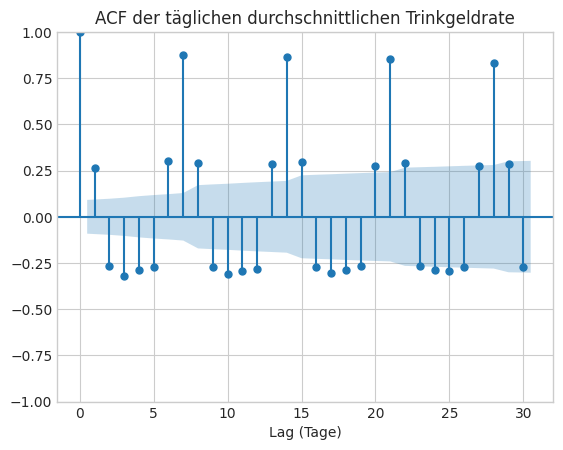

<Figure size 1200x400 with 0 Axes>

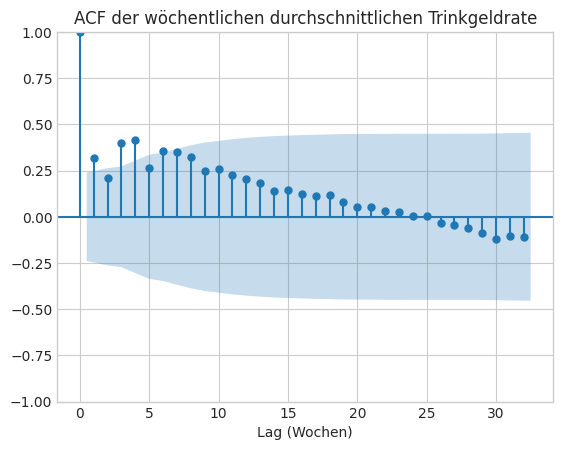

<Figure size 1200x400 with 0 Axes>

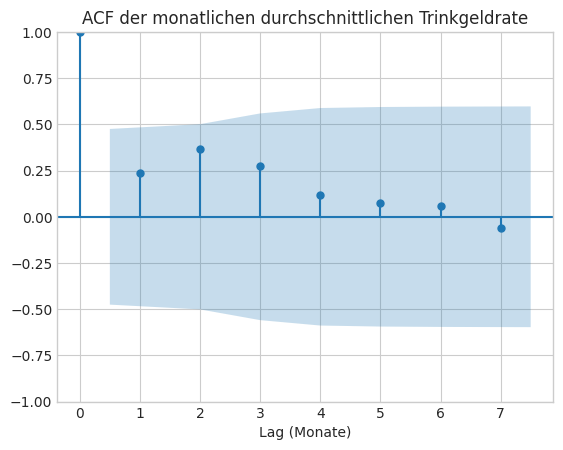

In [8]:
if not df_eda.empty and 'tip_given' in df_eda.columns:
    plt.figure(figsize=(15, 12)) 

    # Wochentag
    if 'day_of_week' in df_eda.columns and 'tip_rate_by_dow' in locals():
        plt.subplot(2, 2, 1)
        tip_rate_by_dow.plot(kind='bar', color='skyblue')
        plt.title('Durchschnittliche Trinkgeldrate pro Wochentag')
        plt.xlabel('Wochentag')
        plt.ylabel('Trinkgeldrate')
        plt.xticks(rotation=45)
        plt.ylim(0, max(tip_rate_by_dow.max() * 1.1, 0.1)) 

    # Monat
    if 'month' in df_eda.columns and 'tip_rate_by_month' in locals():
        plt.subplot(2, 2, 2)
        tip_rate_by_month.plot(kind='bar', color='lightcoral')
        plt.title('Durchschnittliche Trinkgeldrate pro Monat')
        plt.xlabel('Monat')
        plt.ylabel('Trinkgeldrate')
        plt.xticks(rotation=45)
        plt.ylim(0, max(tip_rate_by_month.max() * 1.1, 0.1))

    # Quartal
    if 'quarter' in df_eda.columns and 'tip_rate_by_quarter' in locals():
        plt.subplot(2, 2, 3)
        tip_rate_by_quarter.plot(kind='bar', color='lightgreen')
        plt.title('Durchschnittliche Trinkgeldrate pro Quartal')
        plt.xlabel('Quartal')
        plt.ylabel('Trinkgeldrate')
        plt.xticks(rotation=0)
        plt.ylim(0, max(tip_rate_by_quarter.max() * 1.1, 0.1))

    # Wochenende
    if 'is_weekend' in df_eda.columns and 'tip_rate_by_weekend' in locals():
        plt.subplot(2, 2, 4)
        tip_rate_by_weekend.plot(kind='bar', color='gold')
        plt.title('Durchschnittliche Trinkgeldrate: Wochenende vs. Wochentag')
        plt.xlabel('Ist Wochenende?')
        plt.ylabel('Trinkgeldrate')
        plt.xticks(ticks=[0, 1], labels=['Wochentag', 'Wochenende'], rotation=0)
        plt.ylim(0, max(tip_rate_by_weekend.max() * 1.1, 0.1))

    plt.tight_layout() 
    plt.show()

    if 'order_timestamp' in df_eda.columns and pd.api.types.is_datetime64_any_dtype(df_eda['order_timestamp']):
        
        try:
            daily_avg_tip_rate = df_eda.set_index('order_timestamp').resample('D')['tip_given'].mean().dropna()
            if not daily_avg_tip_rate.empty and len(daily_avg_tip_rate) > 1:
                plt.figure(figsize=(12, 4))
                plot_acf(daily_avg_tip_rate, lags=min(30, len(daily_avg_tip_rate)//2 - 1), title='ACF der täglichen durchschnittlichen Trinkgeldrate')
                plt.xlabel("Lag (Tage)")
                plt.show()
            else:
                print("Nicht genügend Daten für ACF der täglichen Trinkgeldrate vorhanden nach Resampling/Dropna.")
        except Exception as e:
            print(f"Fehler beim Erstellen des täglichen ACF-Plots: {e}")

        try:
            weekly_avg_tip_rate = df_eda.set_index('order_timestamp').resample('W')['tip_given'].mean().dropna()
            if not weekly_avg_tip_rate.empty and len(weekly_avg_tip_rate) > 1:
                plt.figure(figsize=(12, 4))
                plot_acf(weekly_avg_tip_rate, lags=min(52, len(weekly_avg_tip_rate)//2 - 1), title='ACF der wöchentlichen durchschnittlichen Trinkgeldrate')
                plt.xlabel("Lag (Wochen)")
                plt.show()
            else:
                print("Nicht genügend Daten für ACF der wöchentlichen Trinkgeldrate vorhanden nach Resampling/Dropna.")
        except Exception as e:
            print(f"Fehler beim Erstellen des wöchentlichen ACF-Plots: {e}")

        try:
            monthly_avg_tip_rate = df_eda.set_index('order_timestamp').resample('MS')['tip_given'].mean().dropna()
            if not monthly_avg_tip_rate.empty and len(monthly_avg_tip_rate) > 1:
                plt.figure(figsize=(12, 4))
                plot_acf(monthly_avg_tip_rate, lags=min(24, len(monthly_avg_tip_rate)//2 - 1), title='ACF der monatlichen durchschnittlichen Trinkgeldrate')
                plt.xlabel("Lag (Monate)")
                plt.show()
            else:
                print("Nicht genügend Daten für ACF der monatlichen Trinkgeldrate vorhanden nach Resampling/Dropna.")
        except Exception as e:
            print(f"Fehler beim Erstellen des monatlichen ACF-Plots: {e}")
            
    else:
        print("Keine Zeitstempeldaten ('order_timestamp') im korrekten Format für ACF-Plots der aggregierten Zeitreihen vorhanden.")
else:
    print("DataFrame für EDA ist leer oder 'tip_given' fehlt. Keine Visualisierungen für Periodizität oder ACF-Plots möglich.")


--- Analyse des Trends im Trinkgeldverhalten ---


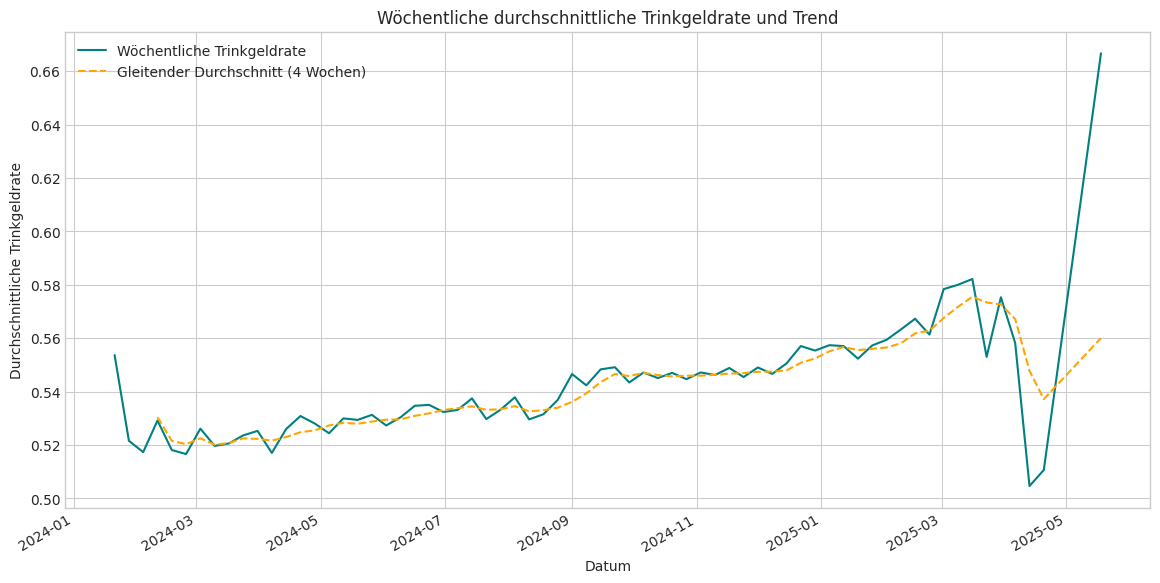

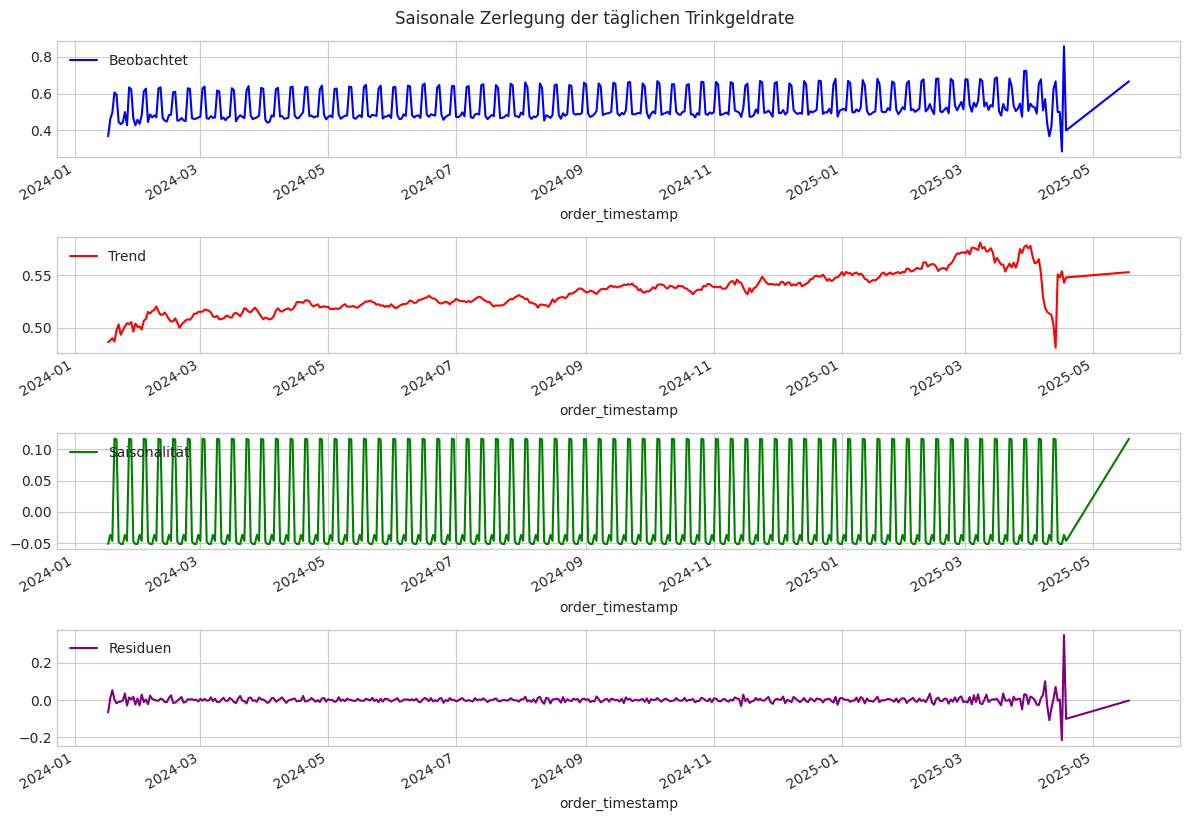

In [9]:
if not df_eda.empty and 'tip_given' in df_eda.columns and 'order_timestamp' in df_eda.columns and pd.api.types.is_datetime64_any_dtype(df_eda['order_timestamp']):
    print("--- Analyse des Trends im Trinkgeldverhalten ---")

    try:
        weekly_tip_rate = df_eda.set_index('order_timestamp').resample('W')['tip_given'].mean().dropna()
        if not weekly_tip_rate.empty:
            plt.figure(figsize=(14, 7))
            weekly_tip_rate.plot(label='Wöchentliche Trinkgeldrate', color='teal')
            
            if len(weekly_tip_rate) >= 4:
                weekly_tip_rate.rolling(window=4).mean().plot(label='Gleitender Durchschnitt (4 Wochen)', color='orange', linestyle='--')
            
            plt.title('Wöchentliche durchschnittliche Trinkgeldrate und Trend')
            plt.xlabel('Datum')
            plt.ylabel('Durchschnittliche Trinkgeldrate')
            plt.legend()
            plt.show()
        else:
            print("Keine Daten für wöchentliche Trinkgeldrate nach Resampling/Dropna.")
    except Exception as e:
        print(f"Fehler bei der Visualisierung der wöchentlichen Trinkgeldrate: {e}")


    if 'daily_avg_tip_rate' in locals() and not daily_avg_tip_rate.empty and len(daily_avg_tip_rate) > 14: 
        try:
            decomposition_period = 7 
            if len(daily_avg_tip_rate) < 2 * decomposition_period:
                 print(f"Zeitreihe zu kurz für saisonale Zerlegung mit Periode {decomposition_period}. Benötigt mind. {2*decomposition_period} Punkte.")
            else:
                decomposition = seasonal_decompose(daily_avg_tip_rate, model='additive', period=decomposition_period, extrapolate_trend='freq')
                
                plt.figure(figsize=(12, 8))
                plt.subplot(411)
                decomposition.observed.plot(label='Beobachtet', color='blue')
                plt.legend(loc='upper left')
                plt.subplot(412)
                decomposition.trend.plot(label='Trend', color='red')
                plt.legend(loc='upper left')
                plt.subplot(413)
                decomposition.seasonal.plot(label='Saisonalität', color='green')
                plt.legend(loc='upper left')
                plt.subplot(414)
                decomposition.resid.plot(label='Residuen', color='purple')
                plt.legend(loc='upper left')
                plt.tight_layout()
                plt.suptitle('Saisonale Zerlegung der täglichen Trinkgeldrate', y=1.02)
                plt.show()
        except ValueError as ve:
            print(f"ValueError bei der saisonalen Zerlegung (möglicherweise zu kurze Zeitreihe oder falsche Periode): {ve}")
        except Exception as e:
            print(f"Fehler bei der saisonalen Zerlegung: {e}")
    else:
        print("Tägliche durchschnittliche Trinkgeldrate ('daily_avg_tip_rate' aus Zelle 2.2) nicht verfügbar oder zu kurz für saisonale Zerlegung.")
else:
    print("DataFrame für EDA ist leer oder relevante Spalten ('tip_given', 'order_timestamp') fehlen/sind im falschen Format.")



### 2.4 Dokumentation der Beobachtungen zu Periodizität und Trend

*Hier Beobachtungen eintragen:*

* **Periodizität:**
    * Wochentag: *[z.B. Gibt es signifikante Unterschiede in der Trinkgeldrate zwischen Wochentagen? Höher am Wochenende?]*
    * Monat: *[z.B. Gibt es Monate mit auffällig höheren oder niedrigeren Trinkgeldratern?]*
    * Quartal: *[z.B. Bestätigen sich monatliche Muster auf Quartalsebene?]*
    * Wochenende: *[z.B. Wie groß ist der Unterschied zwischen Wochenende und Wochentag?]*
    * ACF-Plot (aggregiert): *[z.B. Zeigt der ACF-Plot der aggregierten Zeitreihe klare saisonale Spikes? Wenn ja, bei welchen Lags?]*

* **Trend:**
    * Gleitender Durchschnitt: *[z.B. Zeigt der gleitende Durchschnitt einen aufsteigenden, absteigenden oder seitlichen Trend?]*
    * Saisonale Zerlegung:
        * Trendkomponente: *[z.B. Bestätigt die Zerlegung den visuellen Trend? Ist er linear, nicht-linear?]*
        * Saisonkomponente: *[z.B. Ist eine klare Saisonfigur erkennbar? Welche Periodizität dominiert?]*
        * Residuen: *[z.B. Sind die Residuen zufällig (weißes Rauschen) oder zeigen sie noch Muster?]*

*Diese Beobachtungen fließen später in die Erweiterung des AR-Modells ein (Frage f).*


## 3. Autokorrelation und Partielle Autokorrelation (zur Information für globale Modelle)

Untersuchung der Autokorrelationen (ACF) und partiellen Autokorrelationen (PACF) von *individuellen* Zeitreihen der Trinkgeldgabe. Diese Analyse dient dazu, ein besseres Verständnis für die typische zeitliche Abhängigkeit im Trinkgeldverhalten einzelner User zu gewinnen. Die Erkenntnisse können helfen, potenziell relevante Lag-Variablen als Features für die später zu erstellenden *globalen* AR-Modelle zu identifizieren.



In [10]:
if not df_filtered_users.empty:
    top_n_users = df_filtered_users['user_id'].value_counts().nlargest(3).index.tolist()
    print(f"Top 3 User für ACF/PACF-Analyse (basierend auf Bestellanzahl): {top_n_users}")

    if len(users_with_enough_orders) >= 3: 
        random_selected_users = np.random.choice(users_with_enough_orders, size=min(3, len(users_with_enough_orders)), replace=False).tolist()
        print(f"Zufällig ausgewählte User für ACF/PACF-Analyse: {random_selected_users}")
        
        users_for_acf_pacf = random_selected_users
    elif top_n_users:
        users_for_acf_pacf = top_n_users
        print("Verwende Top-User, da nicht genügend User für eine zufällige Auswahl vorhanden sind.")
    else:
        users_for_acf_pacf = []
        print("Keine User für die ACF/PACF-Analyse ausgewählt (nicht genügend Daten).")

else:
    print("DataFrame 'df_filtered_users' ist leer. Keine User für ACF/PACF-Analyse verfügbar.")
    users_for_acf_pacf = []



Top 3 User für ACF/PACF-Analyse (basierend auf Bestellanzahl): [187550, 187362, 80828]
Zufällig ausgewählte User für ACF/PACF-Analyse: [55973, 141999, 73667]



--- ACF und PACF für User ID: 55973 ---


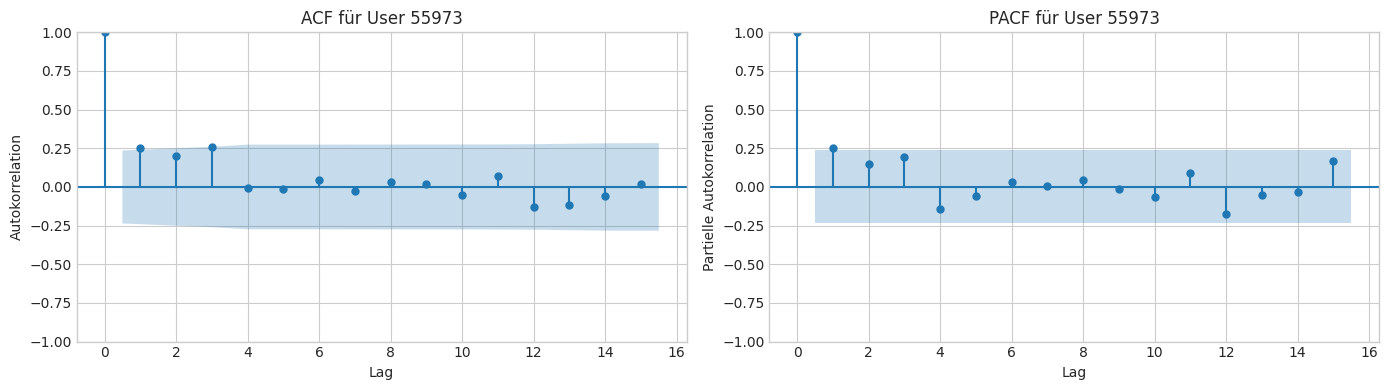


--- ACF und PACF für User ID: 141999 ---


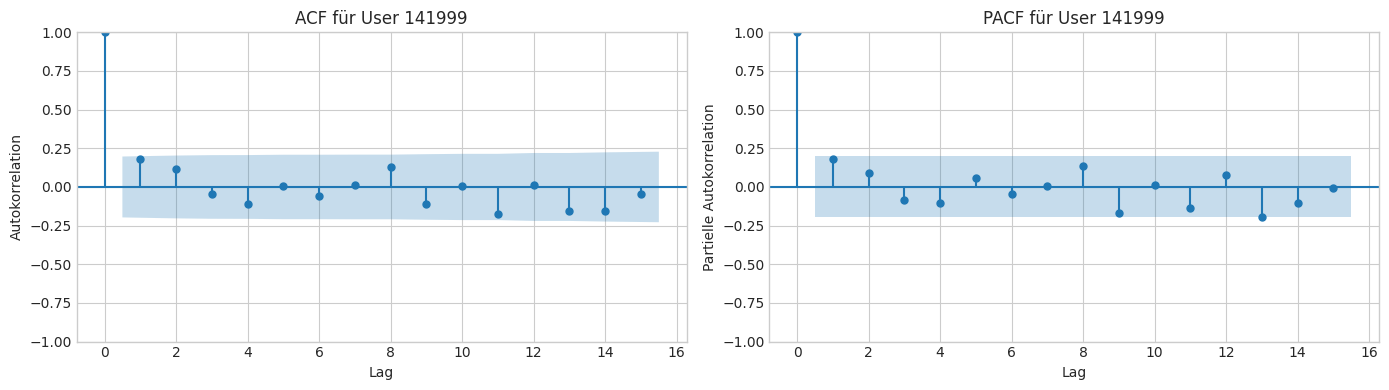


--- ACF und PACF für User ID: 73667 ---


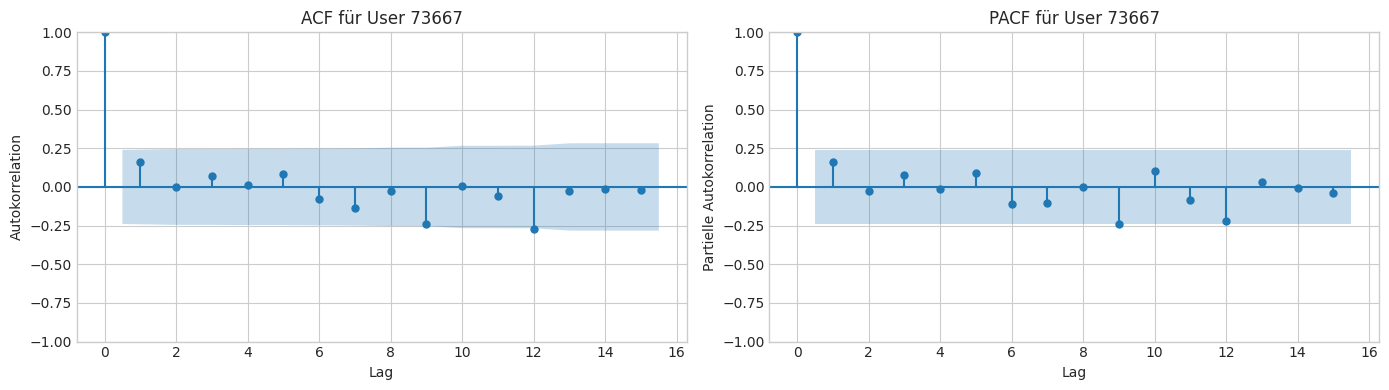

In [11]:

if not df_filtered_users.empty and users_for_acf_pacf:
    MAX_LAGS_ACF_PACF = 15 

    for user_id_to_plot in users_for_acf_pacf:
        print(f"\n--- ACF und PACF für User ID: {user_id_to_plot} ---")
        
        user_series = df_filtered_users[df_filtered_users['user_id'] == user_id_to_plot]['tip_given'].copy()
        
        user_series.dropna(inplace=True)

        if len(user_series) < MAX_LAGS_ACF_PACF + 1 or len(user_series) < 2: 
            print(f"User {user_id_to_plot} hat nicht genügend Datenpunkte ({len(user_series)}) für ACF/PACF mit {MAX_LAGS_ACF_PACF} Lags.")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        
        # ACF Plot
        plot_acf(user_series, ax=axes[0], lags=min(MAX_LAGS_ACF_PACF, len(user_series)//2 - 1), title=f'ACF für User {user_id_to_plot}')
        axes[0].set_xlabel("Lag")
        axes[0].set_ylabel("Autokorrelation")

        # PACF Plot
        plot_pacf(user_series, ax=axes[1], lags=min(MAX_LAGS_ACF_PACF, len(user_series)//2 - 1), method='ywm', title=f'PACF für User {user_id_to_plot}')
        axes[1].set_xlabel("Lag")
        axes[1].set_ylabel("Partielle Autokorrelation")
        
        plt.tight_layout()
        plt.show()
else:
    print("Keine User für die ACF/PACF-Analyse ausgewählt oder DataFrame ist leer.")



### 3.3 Interpretation der ACF/PACF-Plots und Schätzung für AR(n)

*Basierend auf den oben erstellten ACF- und PACF-Plots für repräsentative User:*

* **ACF (Autocorrelation Function):**
    * *[z.B. Beobachtung: Der ACF-Plot für User X zeigt einen langsam abklingenden Verlauf, was auf eine AR-Komponente hindeutet.]*
    * *[z.B. Beobachtung: Für User Y sind die Korrelationen nach Lag 2 nicht mehr signifikant.]*

* **PACF (Partial Autocorrelation Function):**
    * *[z.B. Beobachtung: Der PACF-Plot für User X schneidet nach Lag p=2 signifikant ab. Dies legt eine Ordnung von AR(2) nahe.]*
    * *[z.B. Beobachtung: Für User Z ist nur Lag 1 im PACF signifikant, was auf AR(1) hindeutet.]*

* **Abschätzung für n in AR(n):**
    * *[z.B. Basierend auf der Mehrheit der PACF-Plots oder einem typischen Verhalten scheint ein AR(n)-Modell mit n zwischen 1 und 3 (oder einem anderen Wert) am sinnvollsten zu sein. Für die Aufgabe c werden wir diesen geschätzten Wert für n verwenden.]*
    * *[z.B. Angenommen, die PACF legt für die meisten User eine Ordnung von n=2 oder n=3 nahe. Wir könnten n=3 für das "optimale" AR(n)-Modell in Teil c wählen, da unsere Mart-Tabelle Lags bis 5 enthält.]*

*Diese Abschätzung wird in Schritt 4c verwendet, um das "optimale" AR(n)-Modell zu bauen.*


## 4. Globale AR-Modellierung und Genauigkeitsbewertung (Fragen a, b, c - Teil 2)

Da `tip_given` eine binäre Variable ist (0 oder 1), werden wir die "AR-Modelle" als logistische Regressionsmodelle interpretieren, bei denen die Lag-Variablen des Trinkgeldverhaltens als Features dienen.

Für diese Aufgabe erstellen wir **globale Modelle**, die auf den Daten aller relevanten User trainiert werden. Dies ermöglicht es, allgemeine Muster im Trinkgeldverhalten zu lernen. Die Lag-Variablen stellen dabei die individuelle Bestellhistorie jedes Users als Feature bereit.

**Hinweis zur Aufgabenstellung:** Die ursprüngliche Formulierung "bei den Bestellungen jedes Users" könnte auch user-spezifische Modelle implizieren. Ein globales Modell liefert jedoch eine generalisierte Aussage über die Vorhersagbarkeit basierend auf der Historie. Die Genauigkeit wird dann über alle User im Testset gemittelt. Wenn die Performance stark variiert, könnten weiterführende Analysen user-spezifische Cluster oder Modelle in Betracht ziehen.


In [12]:
df_model_input = df_filtered_users.copy()

if not df_model_input.empty:
    print(f"--- Vorbereitung für globale AR-Modellierung mit {df_model_input['user_id'].nunique()} Usern und {len(df_model_input)} Bestellungen ---")

    if 'user_id' in df_model_input.columns and 'user_order_sequence' in df_model_input.columns:
        df_model_input = df_model_input.sort_values(by=['user_id', 'user_order_sequence']).reset_index(drop=True)
        print("DataFrame ist nach 'user_id' und 'user_order_sequence' sortiert und Index wurde zurückgesetzt.")
    else:
        print("WARNUNG: DataFrame konnte nicht korrekt für die Zeitreihenanalyse sortiert werden. Überprüfe 'user_id' und 'user_order_sequence'.")
        X_train_ar1, X_test_ar1, y_train_ar1, y_test_ar1 = [pd.DataFrame()]*4
        X_train_ar2, X_test_ar2, y_train_ar2, y_test_ar2 = [pd.DataFrame()]*4
        df_model_input = pd.DataFrame() 

    if not df_model_input.empty:
        if 'tip_given_lag1' in df_model_input.columns and 'tip_given' in df_model_input.columns:
            X_ar1_candidate = df_model_input[['tip_given_lag1']].copy()
            y_ar1_target = df_model_input['tip_given'].copy()      

            X_ar1_candidate.index = y_ar1_target.index

            temp_df_ar1 = pd.concat([X_ar1_candidate, y_ar1_target], axis=1).dropna()
            
            X_ar1_global = temp_df_ar1[['tip_given_lag1']]
            y_ar1_global = temp_df_ar1['tip_given']
            
            print(f"AR(1) - Daten nach dropna: X-Shape {X_ar1_global.shape}, y-Shape {y_ar1_global.shape}") 

            if not X_ar1_global.empty:
                X_train_ar1, X_test_ar1, y_train_ar1, y_test_ar1 = train_test_split(
                    X_ar1_global, y_ar1_global, test_size=0.2, shuffle=False
                )
                print(f"Globales AR(1) - Trainingsdaten: {X_train_ar1.shape}, Testdaten: {X_test_ar1.shape}")
                if X_train_ar1.empty or X_test_ar1.empty:
                     print("WARNUNG: Trainings- oder Testset für AR(1) ist nach dem Split leer.")
            else:
                print("Nicht genügend Daten für globales AR(1) nach NaN-Filterung.")
                X_train_ar1, X_test_ar1, y_train_ar1, y_test_ar1 = [pd.DataFrame()]*4
        else:
            print("Spalte 'tip_given_lag1' oder 'tip_given' nicht vorhanden für globales AR(1).")
            X_train_ar1, X_test_ar1, y_train_ar1, y_test_ar1 = [pd.DataFrame()]*4

        if 'tip_given_lag1' in df_model_input.columns and 'tip_given_lag2' in df_model_input.columns and 'tip_given' in df_model_input.columns:
            X_ar2_candidate = df_model_input[['tip_given_lag1', 'tip_given_lag2']].copy() # Explizite Kopie
            y_ar2_target = df_model_input['tip_given'].copy()      # Explizite Kopie

            X_ar2_candidate.index = y_ar2_target.index

            temp_df_ar2 = pd.concat([X_ar2_candidate, y_ar2_target], axis=1).dropna()

            X_ar2_global = temp_df_ar2[['tip_given_lag1', 'tip_given_lag2']]
            y_ar2_global = temp_df_ar2['tip_given']

            print(f"AR(2) - Daten nach dropna: X-Shape {X_ar2_global.shape}, y-Shape {y_ar2_global.shape}") # Debug

            if not X_ar2_global.empty:
                X_train_ar2, X_test_ar2, y_train_ar2, y_test_ar2 = train_test_split(
                    X_ar2_global, y_ar2_global, test_size=0.2, shuffle=False
                )
                print(f"Globales AR(2) - Trainingsdaten: {X_train_ar2.shape}, Testdaten: {X_test_ar2.shape}")
                if X_train_ar2.empty or X_test_ar2.empty:
                     print("WARNUNG: Trainings- oder Testset für AR(2) ist nach dem Split leer.")
            else:
                print("Nicht genügend Daten für globales AR(2) nach NaN-Filterung.")
                X_train_ar2, X_test_ar2, y_train_ar2, y_test_ar2 = [pd.DataFrame()]*4
        else:
            print("Spalten für globales AR(2) oder 'tip_given' nicht vollständig vorhanden.")
            X_train_ar2, X_test_ar2, y_train_ar2, y_test_ar2 = [pd.DataFrame()]*4
else:
    print("DataFrame 'df_filtered_users' ist leer. Modellvorbereitung für globale Modelle übersprungen.")
    X_train_ar1, X_test_ar1, y_train_ar1, y_test_ar1 = [pd.DataFrame()]*4
    X_train_ar2, X_test_ar2, y_train_ar2, y_test_ar2 = [pd.DataFrame()]*4


--- Vorbereitung für globale AR-Modellierung mit 36154 Usern und 1313565 Bestellungen ---
DataFrame ist nach 'user_id' und 'user_order_sequence' sortiert und Index wurde zurückgesetzt.
AR(1) - Daten nach dropna: X-Shape (1241073, 1), y-Shape (1241073,)
Globales AR(1) - Trainingsdaten: (992858, 1), Testdaten: (248215, 1)
AR(2) - Daten nach dropna: X-Shape (1204911, 2), y-Shape (1204911,)
Globales AR(2) - Trainingsdaten: (963928, 2), Testdaten: (240983, 2)


___
#### debug

In [13]:
if 'X_ar1_global' in locals() and not X_ar1_global.empty:
    analysis_df_ar1 = pd.concat([X_ar1_global, y_ar1_global], axis=1)
    print("Kreuztabelle tip_given vs. tip_given_lag1 (normalisiert nach Zeile):")
    print(pd.crosstab(analysis_df_ar1['tip_given_lag1'], analysis_df_ar1['tip_given'], normalize='index'))

    print("\nAbsolute Häufigkeiten:")
    print(pd.crosstab(analysis_df_ar1['tip_given_lag1'], analysis_df_ar1['tip_given']))
else:
    print("Globale Daten für AR(1) (X_ar1_global) nicht verfügbar für Kreuztabellenanalyse.")

Kreuztabelle tip_given vs. tip_given_lag1 (normalisiert nach Zeile):
tip_given            0.0       1.0
tip_given_lag1                    
0.0             0.709777  0.290223
1.0             0.249440  0.750560

Absolute Häufigkeiten:
tip_given          0.0     1.0
tip_given_lag1                
0.0             408058  166852
1.0             166168  499995


In [14]:
if 'X_train_ar1' in locals() and not X_train_ar1.empty:
    print("Verteilung von tip_given_lag1 im Trainingsset (X_train_ar1):")
    print(X_train_ar1['tip_given_lag1'].value_counts(normalize=True, dropna=False))

Verteilung von tip_given_lag1 im Trainingsset (X_train_ar1):
tip_given_lag1
1.0    0.537103
0.0    0.462897
Name: proportion, dtype: float64


___

### 4.2 Genauigkeitsmetriken

Gemäß der Aufgabenstellung wird primär die **Genauigkeit (`accuracy_score`)** verwendet.
Zusätzlich werden wir uns ansehen:
* **Konfusionsmatrix:** Um True Positives, False Positives, True Negatives und False Negatives zu sehen.
* **Classification Report:** Enthält Precision, Recall und F1-Score pro Klasse.
* **ROC AUC Score:** Ein Maß für die Fähigkeit des Modells, zwischen den Klassen zu unterscheiden (besonders nützlich bei unbalancierten Klassen).

Eine einfache **Baseline-Genauigkeit** für jedes Modell wird ermittelt, indem immer die Mehrheitsklasse aus den Trainingsdaten vorhergesagt und diese Vorhersage auf den Testdaten bewertet wird. Dies gibt uns einen Referenzpunkt, um die Leistung unserer trainierten Modelle zu beurteilen.


--- Globales AR(1)-Modell ---
Baseline Genauigkeit (Mehrheitsklasse '1.0' aus Trainingsdaten): 0.5357
Genauigkeit des globalen AR(1)-Modells: 0.7323

Classification Report für globales AR(1)-Modell:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71    115237
         1.0       0.75      0.75      0.75    132978

    accuracy                           0.73    248215
   macro avg       0.73      0.73      0.73    248215
weighted avg       0.73      0.73      0.73    248215

ROC AUC Score für globales AR(1)-Modell: 0.7309


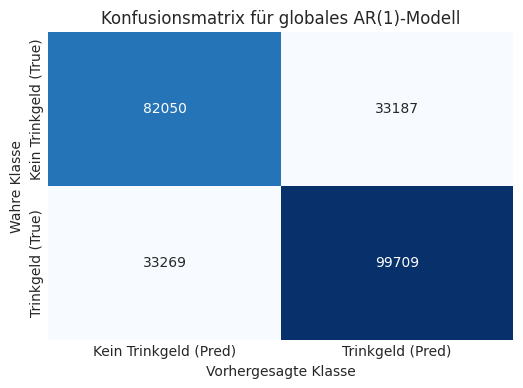

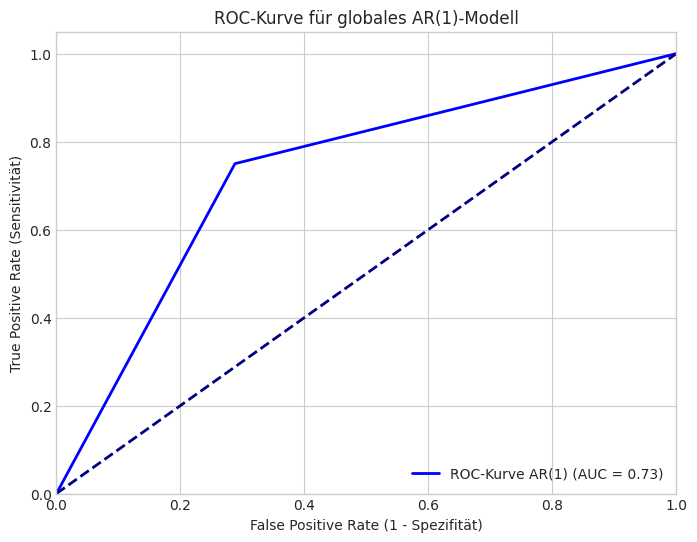

In [15]:
if 'X_train_ar1' in locals() and 'y_train_ar1' in locals() and \
   not X_train_ar1.empty and not y_train_ar1.empty and \
   not X_test_ar1.empty and not y_test_ar1.empty:

    print(f"--- Globales AR(1)-Modell ---")
    
    if not y_train_ar1.empty:
        majority_class_ar1 = y_train_ar1.mode()[0]
        if not y_test_ar1.empty:
            baseline_accuracy_ar1 = accuracy_score(y_test_ar1, [majority_class_ar1] * len(y_test_ar1))
            print(f"Baseline Genauigkeit (Mehrheitsklasse '{majority_class_ar1}' aus Trainingsdaten): {baseline_accuracy_ar1:.4f}")
        else:
            print("Testdaten (y_test_ar1) sind leer, Baseline-Genauigkeit kann nicht berechnet werden.")
            baseline_accuracy_ar1 = np.nan 
    else:
        print("Trainingsdaten (y_train_ar1) sind leer, Mehrheitsklasse für Baseline kann nicht bestimmt werden.")
        baseline_accuracy_ar1 = np.nan 

    model_ar1 = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    model_ar1.fit(X_train_ar1, y_train_ar1)

    y_pred_ar1 = model_ar1.predict(X_test_ar1)
    y_pred_proba_ar1 = model_ar1.predict_proba(X_test_ar1)[:, 1] 

    accuracy_ar1 = accuracy_score(y_test_ar1, y_pred_ar1)
    print(f"Genauigkeit des globalen AR(1)-Modells: {accuracy_ar1:.4f}")

    print("\nClassification Report für globales AR(1)-Modell:")
    print(classification_report(y_test_ar1, y_pred_ar1, zero_division=0))
    
    roc_auc_ar1 = np.nan 
    if len(np.unique(y_test_ar1)) > 1:
        try:
            roc_auc_ar1 = roc_auc_score(y_test_ar1, y_pred_proba_ar1)
            print(f"ROC AUC Score für globales AR(1)-Modell: {roc_auc_ar1:.4f}")
        except ValueError as ve:
            print(f"Fehler bei der Berechnung des ROC AUC Scores für AR(1): {ve}")
    else:
        print("ROC AUC konnte nicht berechnet werden, da nur eine Klasse in y_test_ar1 vorhanden ist.")

    cm_ar1 = confusion_matrix(y_test_ar1, y_pred_ar1)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_ar1, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Kein Trinkgeld (Pred)', 'Trinkgeld (Pred)'],
                yticklabels=['Kein Trinkgeld (True)', 'Trinkgeld (True)'])
    plt.title('Konfusionsmatrix für globales AR(1)-Modell')
    plt.ylabel('Wahre Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

    if not np.isnan(roc_auc_ar1) and len(np.unique(y_test_ar1)) > 1:
        fpr_ar1, tpr_ar1, thresholds_ar1 = roc_curve(y_test_ar1, y_pred_proba_ar1)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_ar1, tpr_ar1, color='blue', lw=2, label=f'ROC-Kurve AR(1) (AUC = {roc_auc_ar1:.2f})') 
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Spezifität)')
        plt.ylabel('True Positive Rate (Sensitivität)')
        plt.title('ROC-Kurve für globales AR(1)-Modell') 
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    elif len(np.unique(y_test_ar1)) <= 1 :
        print("ROC-Kurve für AR(1) nicht erstellt, da nur eine Klasse im Testset vorhanden ist.")
    else:
        print("ROC-Kurve für AR(1) nicht erstellt, da der ROC AUC Score nicht berechnet werden konnte.")
else:
    print("Nicht genügend (globale) Trainings- oder Testdaten für das AR(1)-Modell vorhanden.")
    accuracy_ar1 = np.nan 
    roc_auc_ar1 = np.nan



--- Globales AR(2)-Modell ---
Baseline Genauigkeit (Mehrheitsklasse '1.0' für AR(2)-Testdaten): 0.5358
Genauigkeit des globalen AR(2)-Modells: 0.7325
Vergleich zu globaler AR(1)-Genauigkeit: 0.7323

Classification Report für globales AR(2)-Modell:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71    111868
         1.0       0.75      0.75      0.75    129115

    accuracy                           0.73    240983
   macro avg       0.73      0.73      0.73    240983
weighted avg       0.73      0.73      0.73    240983

ROC AUC Score für globales AR(2)-Modell: 0.7768


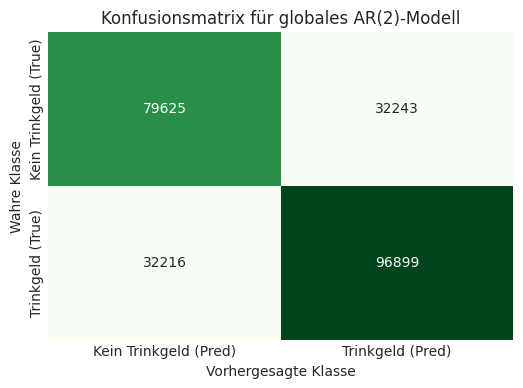

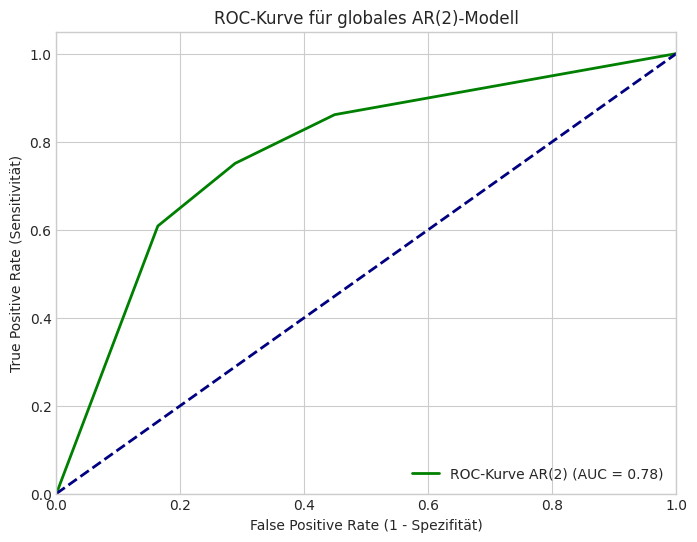

In [16]:
if 'X_train_ar2' in locals() and 'y_train_ar2' in locals() and \
   not X_train_ar2.empty and not y_train_ar2.empty and \
   not X_test_ar2.empty and not y_test_ar2.empty:

    print(f"\n--- Globales AR(2)-Modell ---")

    if not y_train_ar2.empty:
        majority_class_ar2 = y_train_ar2.mode()[0]
        if not y_test_ar2.empty:
            baseline_accuracy_ar2 = accuracy_score(y_test_ar2, [majority_class_ar2] * len(y_test_ar2))
            print(f"Baseline Genauigkeit (Mehrheitsklasse '{majority_class_ar2}' für AR(2)-Testdaten): {baseline_accuracy_ar2:.4f}")
        else:
            print("Testdaten (y_test_ar2) sind leer, Baseline-Genauigkeit für AR(2) kann nicht berechnet werden.")
            baseline_accuracy_ar2 = np.nan
    else:
        print("Trainingsdaten (y_train_ar2) sind leer, Mehrheitsklasse für AR(2)-Baseline kann nicht bestimmt werden.")
        baseline_accuracy_ar2 = np.nan


    model_ar2 = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    model_ar2.fit(X_train_ar2, y_train_ar2)

    y_pred_ar2 = model_ar2.predict(X_test_ar2)
    y_pred_proba_ar2 = model_ar2.predict_proba(X_test_ar2)[:, 1] 

    accuracy_ar2 = accuracy_score(y_test_ar2, y_pred_ar2)
    print(f"Genauigkeit des globalen AR(2)-Modells: {accuracy_ar2:.4f}")
    
    if 'accuracy_ar1' in locals() and not np.isnan(accuracy_ar1):
        print(f"Vergleich zu globaler AR(1)-Genauigkeit: {accuracy_ar1:.4f}")
    else:
        print("AR(1)-Genauigkeit nicht verfügbar für Vergleich.")

    print("\nClassification Report für globales AR(2)-Modell:")
    print(classification_report(y_test_ar2, y_pred_ar2, zero_division=0))
    
    roc_auc_ar2 = np.nan 
    if len(np.unique(y_test_ar2)) > 1:
        try:
            roc_auc_ar2 = roc_auc_score(y_test_ar2, y_pred_proba_ar2)
            print(f"ROC AUC Score für globales AR(2)-Modell: {roc_auc_ar2:.4f}")
        except ValueError as ve:
            print(f"Fehler bei der Berechnung des ROC AUC Scores für AR(2): {ve}")
    else:
        print("ROC AUC konnte nicht berechnet werden, da nur eine Klasse in y_test_ar2 vorhanden ist.")

    cm_ar2 = confusion_matrix(y_test_ar2, y_pred_ar2)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_ar2, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Kein Trinkgeld (Pred)', 'Trinkgeld (Pred)'],
                yticklabels=['Kein Trinkgeld (True)', 'Trinkgeld (True)'])
    plt.title('Konfusionsmatrix für globales AR(2)-Modell')
    plt.ylabel('Wahre Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

    if not np.isnan(roc_auc_ar2) and len(np.unique(y_test_ar2)) > 1:
        fpr_ar2, tpr_ar2, thresholds_ar2 = roc_curve(y_test_ar2, y_pred_proba_ar2)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_ar2, tpr_ar2, color='green', lw=2, label=f'ROC-Kurve AR(2) (AUC = {roc_auc_ar2:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Spezifität)')
        plt.ylabel('True Positive Rate (Sensitivität)')
        plt.title('ROC-Kurve für globales AR(2)-Modell')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    elif len(np.unique(y_test_ar2)) <= 1 :
        print("ROC-Kurve für AR(2) nicht erstellt, da nur eine Klasse im Testset vorhanden ist.")
    else:
        print("ROC-Kurve für AR(2) nicht erstellt, da der ROC AUC Score nicht berechnet werden konnte.")
else:
    print("Nicht genügend (globale) Trainings- oder Testdaten für das AR(2)-Modell vorhanden.")
    accuracy_ar2 = np.nan
    roc_auc_ar2 = np.nan



--- Globales Optimales AR(4)-Modell ---
Globales AR(4) - Trainingsdaten: (906080, 4), Testdaten: (226520, 4)
Baseline Genauigkeit (Mehrheitsklasse '1.0' für AR(4)-Testdaten): 0.5361
Genauigkeit des globalen AR(4)-Modells: 0.7408
Vergleich zu globaler AR(1)-Genauigkeit: 0.7323
Vergleich zu globaler AR(2)-Genauigkeit: 0.7325

Classification Report für globales AR(4)-Modell:
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72    105087
         1.0       0.76      0.76      0.76    121433

    accuracy                           0.74    226520
   macro avg       0.74      0.74      0.74    226520
weighted avg       0.74      0.74      0.74    226520

ROC AUC Score für globales AR(4)-Modell: 0.8071


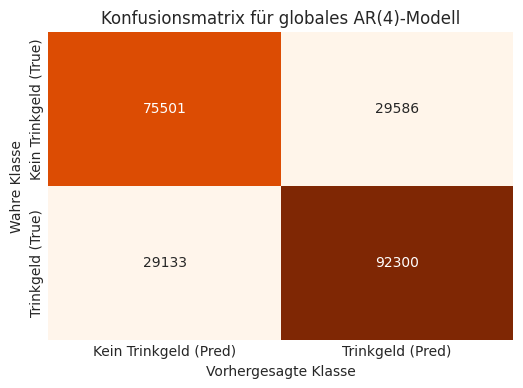

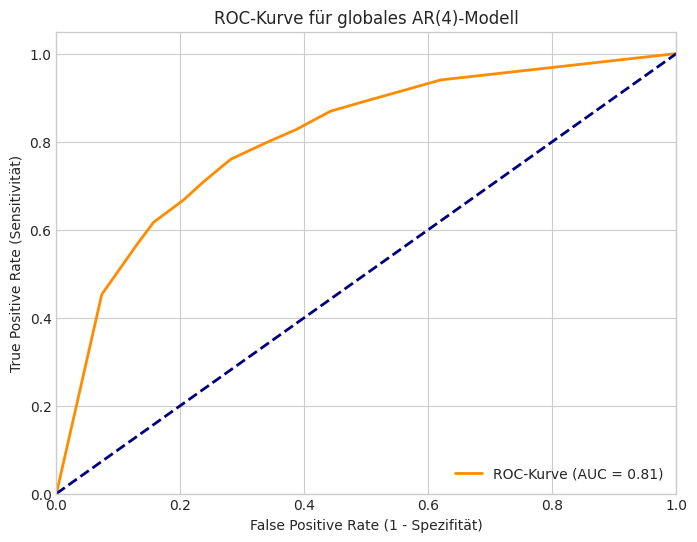

In [17]:
if 'df_model_input' in locals() and not df_model_input.empty:
    OPTIMAL_N = 4  
    
    print(f"\n--- Globales Optimales AR({OPTIMAL_N})-Modell ---")

    required_lag_cols_arn = [f'tip_given_lag{i}' for i in range(1, OPTIMAL_N + 1)]
    
    if not all(col in df_model_input.columns for col in required_lag_cols_arn):
        max_available_lag = 0
        if any(df_model_input.columns.str.startswith('tip_given_lag')):
            max_available_lag = df_model_input.columns[df_model_input.columns.str.startswith('tip_given_lag')].str.extract(r'(\d+)').astype(int).max().iloc[0]
        print(f"Nicht alle benötigten Lag-Spalten für AR({OPTIMAL_N}) vorhanden. Maximal verfügbarer Lag ist {max_available_lag}.")
        print(f"Passe OPTIMAL_N ggf. an oder überprüfe den Mart 'mart_user_tipping_behavior_timeseries'.")
        X_train_arn, X_test_arn, y_train_arn, y_test_arn = [pd.DataFrame()]*4 
        accuracy_arn = np.nan
        roc_auc_arn = np.nan
    else:
        X_arn_candidate_global = df_model_input[required_lag_cols_arn]
        y_global_for_arn = df_model_input['tip_given'] 

        temp_df_arn = pd.concat([X_arn_candidate_global, y_global_for_arn], axis=1).dropna()
            
        X_arn_global = temp_df_arn[required_lag_cols_arn]
        y_arn_global = temp_df_arn['tip_given']

        if not X_arn_global.empty and len(X_arn_global) > OPTIMAL_N :
            X_train_arn, X_test_arn, y_train_arn, y_test_arn = train_test_split(
                X_arn_global, y_arn_global, test_size=0.2, shuffle=False
            )
            print(f"Globales AR({OPTIMAL_N}) - Trainingsdaten: {X_train_arn.shape}, Testdaten: {X_test_arn.shape}")
            if X_train_arn.empty or X_test_arn.empty:
                 print(f"WARNUNG: Trainings- oder Testset für AR({OPTIMAL_N}) ist nach dem Split leer.")

            if not y_train_arn.empty and not y_test_arn.empty:
                majority_class_arn = y_train_arn.mode()[0]
                baseline_accuracy_arn = accuracy_score(y_test_arn, [majority_class_arn] * len(y_test_arn))
                print(f"Baseline Genauigkeit (Mehrheitsklasse '{majority_class_arn}' für AR({OPTIMAL_N})-Testdaten): {baseline_accuracy_arn:.4f}")
            else:
                print("Trainings- oder Testdaten für AR(n)-Baseline sind leer.")
                baseline_accuracy_arn = np.nan

            model_arn = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
            model_arn.fit(X_train_arn, y_train_arn)

            y_pred_arn = model_arn.predict(X_test_arn)
            y_pred_proba_arn = model_arn.predict_proba(X_test_arn)[:, 1] 

            accuracy_arn = accuracy_score(y_test_arn, y_pred_arn)
            print(f"Genauigkeit des globalen AR({OPTIMAL_N})-Modells: {accuracy_arn:.4f}")
            
            if 'accuracy_ar1' in locals() and not np.isnan(accuracy_ar1): print(f"Vergleich zu globaler AR(1)-Genauigkeit: {accuracy_ar1:.4f}")
            if 'accuracy_ar2' in locals() and not np.isnan(accuracy_ar2): print(f"Vergleich zu globaler AR(2)-Genauigkeit: {accuracy_ar2:.4f}")

            print(f"\nClassification Report für globales AR({OPTIMAL_N})-Modell:")
            print(classification_report(y_test_arn, y_pred_arn, zero_division=0))

            roc_auc_arn = np.nan 
            if len(np.unique(y_test_arn)) > 1:
                try:
                    roc_auc_arn = roc_auc_score(y_test_arn, y_pred_proba_arn)
                    print(f"ROC AUC Score für globales AR({OPTIMAL_N})-Modell: {roc_auc_arn:.4f}")
                except ValueError as ve:
                    print(f"Fehler bei der Berechnung des ROC AUC Scores für AR({OPTIMAL_N}): {ve}")
            else:
                print(f"ROC AUC konnte nicht berechnet werden (nur eine Klasse in y_test_arn für AR({OPTIMAL_N})).")

            cm_arn = confusion_matrix(y_test_arn, y_pred_arn)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm_arn, annot=True, fmt='d', cmap='Oranges', cbar=False,
                        xticklabels=['Kein Trinkgeld (Pred)', 'Trinkgeld (Pred)'],
                        yticklabels=['Kein Trinkgeld (True)', 'Trinkgeld (True)'])
            plt.title(f'Konfusionsmatrix für globales AR({OPTIMAL_N})-Modell')
            plt.ylabel('Wahre Klasse')
            plt.xlabel('Vorhergesagte Klasse')
            plt.show()

            if not np.isnan(roc_auc_arn) and len(np.unique(y_test_arn)) > 1: 
                fpr, tpr, thresholds = roc_curve(y_test_arn, y_pred_proba_arn)
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-Kurve (AUC = {roc_auc_arn:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate (1 - Spezifität)')
                plt.ylabel('True Positive Rate (Sensitivität)')
                plt.title(f'ROC-Kurve für globales AR({OPTIMAL_N})-Modell')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            elif len(np.unique(y_test_arn)) <= 1 :
                 print("ROC-Kurve nicht erstellt, da nur eine Klasse im Testset vorhanden ist.")
            else:
                print("ROC-Kurve nicht erstellt, da der ROC AUC Score nicht berechnet werden konnte.")
        else:
            print(f"Nicht genügend Daten für das globale AR({OPTIMAL_N})-Modell nach NaN-Filterung.")
            accuracy_arn = np.nan
            roc_auc_arn = np.nan
else:
    print("DataFrame 'df_model_input' ist leer. Globales AR(n)-Modell übersprungen.")
    accuracy_arn = np.nan
    roc_auc_arn = np.nan


## 5. Erweitertes Prognosemodell (Frage f)

Basierend auf den Erkenntnissen aus der EDA (Periodizität, Trend) und dem besten AR(n)-Modell erweitern wir nun das Modell.


In [41]:
from sklearn.preprocessing import StandardScaler 
import numpy as np 

if 'OPTIMAL_N' not in locals() or pd.isna(OPTIMAL_N) or OPTIMAL_N is None:
    print("WARNUNG: 'OPTIMAL_N' wurde nicht aus dem vorherigen AR(n)-Modell (Zelle 4.5) übernommen oder ist ungültig.")
    print("Setze OPTIMAL_N auf einen Standardwert (z.B. 3) für dieses erweiterte Modell.")
    print("Überprüfe Zelle 4.5 für die korrekte Bestimmung von OPTIMAL_N.")
    OPTIMAL_N = 3
    if 'accuracy_arn' in locals(): 
        if pd.isna(accuracy_arn): OPTIMAL_N = 0 

if 'df_model_input' in locals() and not df_model_input.empty:
    print(f"--- Feature Engineering für globales erweitertes Modell (basierend auf AR({OPTIMAL_N})) ---")
    
    df_model_extended = df_model_input.copy()

    lag_features = []
    if OPTIMAL_N > 0:
        required_lag_cols_ext = [f'tip_given_lag{i}' for i in range(1, OPTIMAL_N + 1)]
        if all(col in df_model_extended.columns for col in required_lag_cols_ext):
            lag_features = required_lag_cols_ext
            print(f"Verwendete Lag-Features (bis N={OPTIMAL_N}): {lag_features}")
        else:
            print(f"WARNUNG: Nicht alle Lag-Features bis N={OPTIMAL_N} sind in df_model_extended vorhanden.")
            lag_features = [col for col in required_lag_cols_ext if col in df_model_extended.columns]
            if lag_features: print(f"Verwende stattdessen die vorhandenen Lag-Features: {lag_features}")
            else: print("Keine Lag-Features für das erweiterte Modell verfügbar.")
    else:
        print("OPTIMAL_N ist 0 oder nicht definiert, keine Lag-Features werden verwendet.")

    trend_feature_name = 'user_order_sequence'
    trend_features_to_use = [] 
    print(f"Trend-Feature '{trend_feature_name}' wird NICHT für das erweiterte Modell verwendet.")


    cyclical_features_created = []
    
    day_of_week_col_original = 'day_of_week' 
    day_of_week_col_numeric = 'day_of_week_numeric_for_sin_cos' 

    if day_of_week_col_original in df_model_extended.columns:
        day_map = {
            'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
            'Friday': 4, 'Saturday': 5, 'Sunday': 6,
            'Montag': 0, 'Dienstag': 1, 'Mittwoch': 2, 'Donnerstag': 3,
            'Freitag': 4, 'Samstag': 5, 'Sonntag': 6
        }
        if pd.api.types.is_string_dtype(df_model_extended[day_of_week_col_original]):
            df_model_extended[day_of_week_col_numeric] = df_model_extended[day_of_week_col_original].map(day_map)
        elif pd.api.types.is_numeric_dtype(df_model_extended[day_of_week_col_original]):
            df_model_extended[day_of_week_col_numeric] = df_model_extended[day_of_week_col_original]
        else:
            print(f"WARNUNG: Unerwarteter Datentyp für '{day_of_week_col_original}'. Überspringe Sin/Cos für Wochentag.")
            df_model_extended[day_of_week_col_numeric] = np.nan

        if not df_model_extended[day_of_week_col_numeric].isnull().all():
            df_model_extended['day_of_week_sin'] = np.sin(2 * np.pi * df_model_extended[day_of_week_col_numeric] / 7)
            df_model_extended['day_of_week_cos'] = np.cos(2 * np.pi * df_model_extended[day_of_week_col_numeric] / 7)
            cyclical_features_created.extend(['day_of_week_sin', 'day_of_week_cos'])
            print("Sin/Cos-Features für Wochentag erstellt.")
        else:
            print(f"Spalte '{day_of_week_col_numeric}' konnte nicht für Sin/Cos-Transformation verwendet werden (enthält nur NaNs oder wurde nicht erstellt).")
    else:
        print(f"WARNUNG: Spalte '{day_of_week_col_original}' nicht im DataFrame für Sin/Cos-Transformation des Wochentags.")


    periodicity_features_categorical_candidates = []
    if 'is_weekend' in df_model_extended.columns:
        periodicity_features_categorical_candidates.append('is_weekend')

    periodicity_features_numerical = []


    print(f"\nKategoriale Periodizitäts-Features für One-Hot-Encoding: {periodicity_features_categorical_candidates}")
    print(f"Erstellte zyklische (Sin/Cos) Features: {cyclical_features_created}")
    print(f"Direkt verwendete numerische Periodizitäts-Features: {periodicity_features_numerical}")
    
    created_dummy_columns = []
    if periodicity_features_categorical_candidates:
        existing_cat_features = [col for col in periodicity_features_categorical_candidates if col in df_model_extended.columns]
        if existing_cat_features:
            try:
                for col in existing_cat_features:
                    if df_model_extended[col].dtype == 'boolean': # Pandas Boolean-Typ
                        df_model_extended[col] = df_model_extended[col].astype(int)
                    elif df_model_extended[col].dtype == 'bool': # NumPy Boolean-Typ
                        df_model_extended[col] = df_model_extended[col].astype(int)
                
                df_with_dummies = pd.get_dummies(df_model_extended[existing_cat_features],
                                                 columns=existing_cat_features,
                                                 drop_first=True,
                                                 dtype=int)
                created_dummy_columns = df_with_dummies.columns.tolist()
                df_model_extended = pd.concat([df_model_extended.drop(columns=existing_cat_features, errors='ignore'), df_with_dummies], axis=1)
                print(f"One-Hot-Encoded Features erstellt: {created_dummy_columns}")
            except Exception as e:
                print(f"Fehler beim Erstellen der One-Hot-Encoded Features: {e}")
                created_dummy_columns = []
        else:
            print("Keine der spezifizierten kategorialen Features für OHE im DataFrame gefunden.")
    
    all_features = lag_features + trend_features_to_use + cyclical_features_created + periodicity_features_numerical + created_dummy_columns
    
    all_features = sorted(list(set(col for col in all_features if col in df_model_extended.columns)))
    
    print(f"\nAlle Features für das erweiterte globale Modell (vor Skalierung): {all_features}")

    if 'tip_given' in df_model_extended.columns:
        y_extended_global = df_model_extended['tip_given'].copy()
        
        if all_features: 
            X_extended_candidate_global = df_model_extended[all_features].copy()
            
            X_extended_candidate_global.index = y_extended_global.index 

            temp_df_extended = pd.concat([X_extended_candidate_global, y_extended_global], axis=1).dropna()
            
            X_extended_global = temp_df_extended[all_features]
            y_extended_global = temp_df_extended['tip_given']

            if not X_extended_global.empty:
                X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
                    X_extended_global, y_extended_global, test_size=0.2, shuffle=False
                )
                print(f"Globales Erweitertes Modell - Trainingsdaten: {X_train_ext.shape}, Testdaten: {X_test_ext.shape}")
                if X_train_ext.empty or X_test_ext.empty:
                    print("WARNUNG: Trainings- oder Testset für erweitertes Modell ist nach dem Split leer.")
            else:
                print("Nicht genügend Daten für globales erweitertes Modell nach NaN-Filterung oder Feature-Auswahl.")
                X_train_ext, X_test_ext, y_train_ext, y_test_ext = [pd.DataFrame()]*4
        else:
            print("Keine Features für das erweiterte Modell ausgewählt oder vorhanden. Überspringe Split.")
            X_train_ext, X_test_ext, y_train_ext, y_test_ext = [pd.DataFrame()]*4
    else:
        print("Zielvariable 'tip_given' nicht in df_model_extended gefunden.")
        X_train_ext, X_test_ext, y_train_ext, y_test_ext = [pd.DataFrame()]*4

else:
    print("DataFrame 'df_model_input' ist leer. Feature Engineering für globales erweitertes Modell übersprungen.")
    X_train_ext, X_test_ext, y_train_ext, y_test_ext = [pd.DataFrame()]*4
    OPTIMAL_N = 0 
    all_features = []

print("\nFeature Engineering abgeschlossen. Die Daten sind für den Train-Test-Split vorbereitet.")
print("In der nächsten Zelle (5.2) werden die Features skaliert und das Modell trainiert.")


--- Feature Engineering für globales erweitertes Modell (basierend auf AR(4)) ---
Verwendete Lag-Features (bis N=4): ['tip_given_lag1', 'tip_given_lag2', 'tip_given_lag3', 'tip_given_lag4']
Trend-Feature 'user_order_sequence' wird NICHT für das erweiterte Modell verwendet.
Sin/Cos-Features für Wochentag erstellt.

Kategoriale Periodizitäts-Features für One-Hot-Encoding: ['is_weekend']
Erstellte zyklische (Sin/Cos) Features: ['day_of_week_sin', 'day_of_week_cos']
Direkt verwendete numerische Periodizitäts-Features: []
One-Hot-Encoded Features erstellt: ['is_weekend_1']

Alle Features für das erweiterte globale Modell (vor Skalierung): ['day_of_week_cos', 'day_of_week_sin', 'is_weekend_1', 'tip_given_lag1', 'tip_given_lag2', 'tip_given_lag3', 'tip_given_lag4']
Globales Erweitertes Modell - Trainingsdaten: (906080, 7), Testdaten: (226520, 7)

Feature Engineering abgeschlossen. Die Daten sind für den Train-Test-Split vorbereitet.
In der nächsten Zelle (5.2) werden die Features skaliert und


--- Globales Erweitertes Prognosemodell (AR(4) + Trend + Periodizität) ---
Features wurden mit StandardScaler skaliert.
Shape X_train_ext_scaled: (906080, 7), Shape X_test_ext_scaled: (226520, 7)
Baseline Genauigkeit (Mehrheitsklasse '1.0' für erweiterte Testdaten): 0.5361
Trainiere Logistische Regression mit C=10...
Genauigkeit des globalen erweiterten Modells: 0.7429
Vergleich zu globalem AR(4): 0.7408

Classification Report für globales erweitertes Modell:
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.73    105087
         1.0       0.77      0.74      0.76    121433

    accuracy                           0.74    226520
   macro avg       0.74      0.74      0.74    226520
weighted avg       0.74      0.74      0.74    226520

ROC AUC Score für globales erweitertes Modell: 0.8185


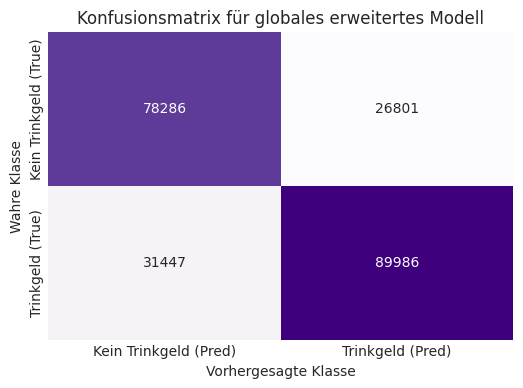

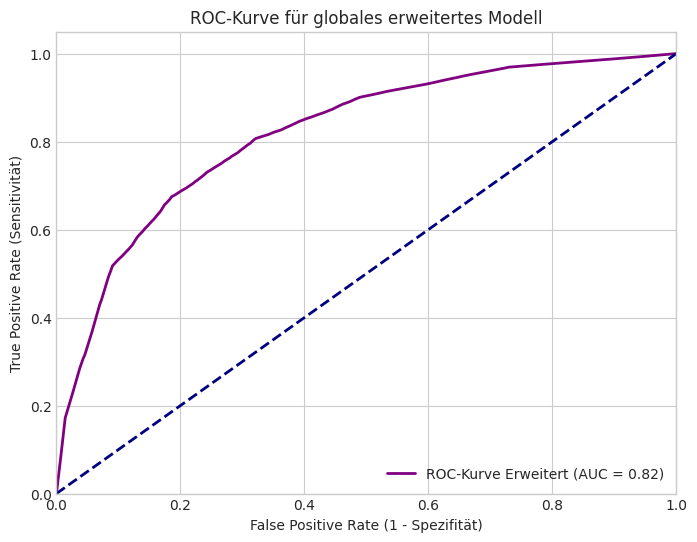


Feature Importance (Koeffizienten der Logistischen Regression) - Erweitertes Modell (auf skalierten Daten):
           feature  coefficient  abs_coefficient
3   tip_given_lag1     0.681370         0.681370
4   tip_given_lag2     0.363708         0.363708
6   tip_given_lag4     0.362377         0.362377
5   tip_given_lag3     0.326416         0.326416
0  day_of_week_cos     0.253593         0.253593
2     is_weekend_1     0.113383         0.113383
1  day_of_week_sin    -0.086159         0.086159


/tmp/ipykernel_1490/3753087950.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=feature_importance.head(20), palette='coolwarm')


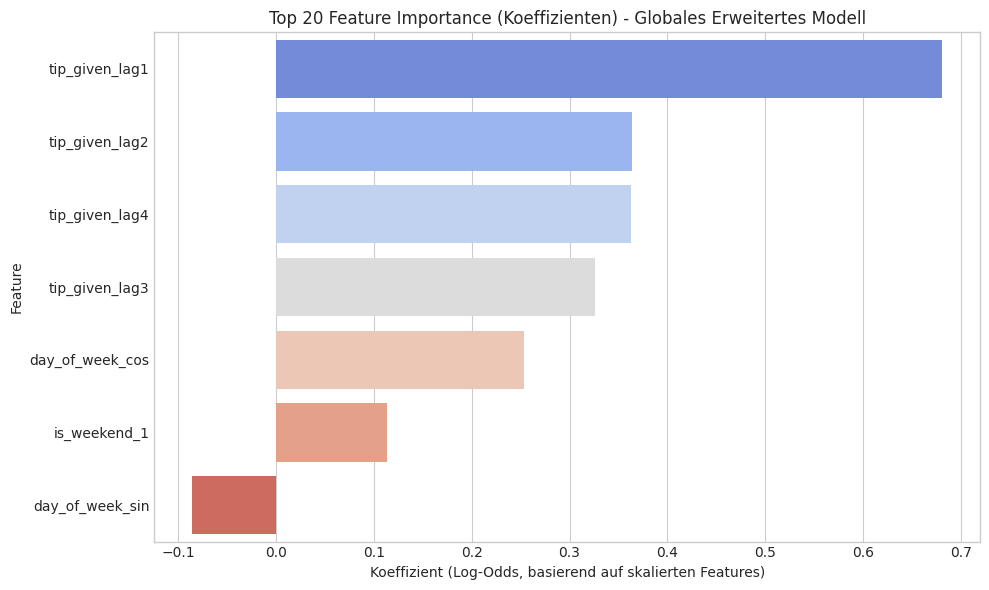


Das finale Modell ('final_model_for_prediction'), der Scaler ('final_model_scaler')
und seine Features ('final_model_features': 7) sind für Schritt 6 bereit.


In [43]:
if 'X_train_ext' in locals() and 'y_train_ext' in locals() and \
   not X_train_ext.empty and not y_train_ext.empty and \
   not X_test_ext.empty and not y_test_ext.empty:

    optimal_n_display = OPTIMAL_N if 'OPTIMAL_N' in locals() and OPTIMAL_N is not None and not pd.isna(OPTIMAL_N) else 'N'
    
    print(f"\n--- Globales Erweitertes Prognosemodell (AR({optimal_n_display}) + Trend + Periodizität) ---")

    feature_names_ext = X_train_ext.columns.tolist()

    scaler = StandardScaler()
    X_train_ext_scaled = scaler.fit_transform(X_train_ext)
    X_test_ext_scaled = scaler.transform(X_test_ext)

    print(f"Features wurden mit StandardScaler skaliert.")
    print(f"Shape X_train_ext_scaled: {X_train_ext_scaled.shape}, Shape X_test_ext_scaled: {X_test_ext_scaled.shape}")

    X_train_ext_scaled_df = pd.DataFrame(X_train_ext_scaled, columns=feature_names_ext, index=X_train_ext.index)
    X_test_ext_scaled_df = pd.DataFrame(X_test_ext_scaled, columns=feature_names_ext, index=X_test_ext.index)


    if not y_train_ext.empty and not y_test_ext.empty:
        majority_class_ext = y_train_ext.mode()[0]
        baseline_accuracy_ext = accuracy_score(y_test_ext, [majority_class_ext] * len(y_test_ext))
        print(f"Baseline Genauigkeit (Mehrheitsklasse '{majority_class_ext}' für erweiterte Testdaten): {baseline_accuracy_ext:.4f}")
    else:
        print("Trainings- oder Testdaten für erweiterte Baseline sind leer.")
        baseline_accuracy_ext = np.nan


    REGULARIZATION_C = 10  
    
    model_extended = LogisticRegression(
        solver='liblinear',
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        C=REGULARIZATION_C
    )
    
    print(f"Trainiere Logistische Regression mit C={REGULARIZATION_C}...")
    model_extended.fit(X_train_ext_scaled_df, y_train_ext) 

    y_pred_ext = model_extended.predict(X_test_ext_scaled_df)
    y_pred_proba_ext = model_extended.predict_proba(X_test_ext_scaled_df)[:, 1]

    accuracy_ext = accuracy_score(y_test_ext, y_pred_ext)
    print(f"Genauigkeit des globalen erweiterten Modells: {accuracy_ext:.4f}")
    
    if 'accuracy_arn' in locals() and not pd.isna(accuracy_arn) and 'OPTIMAL_N' in locals() and OPTIMAL_N is not None and not pd.isna(OPTIMAL_N):
        print(f"Vergleich zu globalem AR({OPTIMAL_N}): {accuracy_arn:.4f}")
    elif 'accuracy_ar2' in locals() and not pd.isna(accuracy_ar2):
        print(f"Vergleich zu globalem AR(2): {accuracy_ar2:.4f}")
    elif 'accuracy_ar1' in locals() and not pd.isna(accuracy_ar1):
        print(f"Vergleich zu globalem AR(1): {accuracy_ar1:.4f}")

    print("\nClassification Report für globales erweitertes Modell:")
    print(classification_report(y_test_ext, y_pred_ext, zero_division=0))

    roc_auc_ext = np.nan
    if len(np.unique(y_test_ext)) > 1:
        try:
            roc_auc_ext = roc_auc_score(y_test_ext, y_pred_proba_ext)
            print(f"ROC AUC Score für globales erweitertes Modell: {roc_auc_ext:.4f}")
        except ValueError as ve:
            print(f"Fehler bei der Berechnung des ROC AUC Scores für erweitertes Modell: {ve}")
    else:
        print("ROC AUC für erweitertes Modell konnte nicht berechnet werden (nur eine Klasse in y_test_ext).")

    cm_ext = confusion_matrix(y_test_ext, y_pred_ext)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_ext, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Kein Trinkgeld (Pred)', 'Trinkgeld (Pred)'],
                yticklabels=['Kein Trinkgeld (True)', 'Trinkgeld (True)'])
    plt.title('Konfusionsmatrix für globales erweitertes Modell')
    plt.ylabel('Wahre Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

    if not pd.isna(roc_auc_ext) and len(np.unique(y_test_ext)) > 1:
        fpr_ext, tpr_ext, thresholds_ext = roc_curve(y_test_ext, y_pred_proba_ext)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_ext, tpr_ext, color='purple', lw=2, label=f'ROC-Kurve Erweitert (AUC = {roc_auc_ext:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Spezifität)')
        plt.ylabel('True Positive Rate (Sensitivität)')
        plt.title('ROC-Kurve für globales erweitertes Modell')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    elif len(np.unique(y_test_ext)) <= 1:
        print("ROC-Kurve für erweitertes Modell nicht erstellt, da nur eine Klasse im Testset vorhanden ist.")
    else:
        print("ROC-Kurve für erweitertes Modell nicht erstellt, da der ROC AUC Score nicht berechnet werden konnte.")


    if hasattr(model_extended, 'coef_'):
        if len(feature_names_ext) == len(model_extended.coef_[0]):
            try:
                feature_importance = pd.DataFrame({'feature': feature_names_ext, 'coefficient': model_extended.coef_[0]})
                feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
                feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)
                
                print("\nFeature Importance (Koeffizienten der Logistischen Regression) - Erweitertes Modell (auf skalierten Daten):")
                print(feature_importance.head(20))

                plt.figure(figsize=(10, max(6, len(feature_importance.head(20)) * 0.35))) 
                sns.barplot(x='coefficient', y='feature', data=feature_importance.head(20), palette='coolwarm')
                plt.title('Top 20 Feature Importance (Koeffizienten) - Globales Erweitertes Modell')
                plt.xlabel('Koeffizient (Log-Odds, basierend auf skalierten Features)')
                plt.ylabel('Feature')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Fehler bei der Darstellung der Feature Importance: {e}")
        else:
            print("Anzahl der Features und Modellkoeffizienten stimmen nicht überein für Feature Importance.")
    else:
        print("Modell hat keine 'coef_'-Attribute für Feature Importance.")
            
    final_model_for_prediction = model_extended
    final_model_scaler = scaler
    final_model_features = feature_names_ext 
    
    print(f"\nDas finale Modell ('final_model_for_prediction'), der Scaler ('final_model_scaler')")
    print(f"und seine Features ('final_model_features': {len(final_model_features)}) sind für Schritt 6 bereit.")

else:
    print("Nicht genügend (globale) Trainings- oder Testdaten für das erweiterte Modell vorhanden.")
    final_model_for_prediction = None
    final_model_scaler = None
    final_model_features = []
    accuracy_ext = np.nan
    roc_auc_ext = np.nan


### 5.1 weitere einflussgrößen (Aufgabe 3)

ideen:
- organic
- mittlere größe einkaufskorb
- bestellung beinhaltet alk

## 6. Vorhersage für Testdatensatz (Frage g)

Erstellung der Vorhersagen für die `order_ids` aus der Datei `tip_testdaten_template.csv` mit dem finalen Modell aus Schritt 5.


## 7. Zusammenfassung und Fazit

*Hier die wichtigsten Ergebnisse zusammenfassen:*

* **Genauigkeit der Modelle:**
    * AR(1): *[Genauigkeit eintragen]*
    * AR(2): *[Genauigkeit eintragen]*
    * Optimales AR(n) (mit n=...): *[Genauigkeit eintragen]*
    * Erweitertes Modell (AR(n) + Trend + Periodizität): *[Genauigkeit eintragen]*

* **Erkenntnisse zur Autokorrelation:**
    * *[Welche Lags waren signifikant in ACF/PACF? Welche Ordnung n wurde für das AR-Modell gewählt und warum?]*

* **Erkenntnisse zu Periodizität und Trend:**
    * Periodizität: *[Gab es signifikante periodische Muster im Trinkgeldverhalten? Welche?]*
    * Trend: *[Gab es einen signifikanten Trend im Trinkgeldverhalten? Welcher Art?]*
    * Einfluss auf erweitertes Modell: *[Hat die Berücksichtigung von Trend und Periodizität die Modellgenauigkeit verbessert? Welche Features waren dabei wichtig?]*

* **Bewertung des finalen Modells:**
    * *[Wie gut ist das finale Modell? Ist es praktisch nutzbar? Welche Einschränkungen gibt es?]*
    * *[Mögliche nächste Schritte zur Verbesserung des Modells.]*
